In [79]:
import os
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from lsst.daf.persistence import Butler

from scipy.stats import norm
import scipy.stats as stats

from astropy.table import Table
import astropy.units as u


from scipy.stats import median_abs_deviation

# import sys
# insert at 1, 0 is the script path (or '' in REPL)
# sys.path.insert(1, '../scripts')
import analysis_utils as au
import data_process_utils as dpu

In [80]:
import imp
imp.reload(au)
imp.reload(dpu)

<module 'data_process_utils' from '/global/cscratch1/sd/shl159/projects/fake_injection_summer_2022/dia_improvement/devel/data_process_utils.py'>

In [81]:
config = 'al_default'

db = (
    f'./data'
    f'/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
flux = pd.read_sql_query('SELECT * FROM fake_src', conn)


In [82]:
flux_det = flux.loc[flux.matched_status.astype(bool)]

In [83]:
config = 'al_default'

db = (
    f'./data'
    f'/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
art = pd.read_sql_query('SELECT * FROM artifact', conn)


In [84]:
len(art), len(flux), len(flux_det)

(48443, 30230, 23893)

 'ip_diffim_DipoleFit_flag_classification': 'clsDp',
            'ip_diffim_DipoleFit_flag_classificationAttempted'

In [85]:
7 * 5 * 20 * 10

7000

In [92]:
def get_confm(flux_df, art_df, flag):
    tp = (art_df[flag]  == 1).sum()
    fp = (flux_df[flag]  == 1).sum()
    tn = (flux_df[flag]  == 0).sum()
    fn = (art_df[flag]  == 0).sum()
    return np.array([tp, fp, tn, fn])

In [93]:
def get_confusion_matrix(flux_df, art_df, flag_cols):
    confusion_matrix = np.array([0, 0, 0, 0])
    flag_list = []
    for flag in flag_cols:
        row = get_confm(flux_df, art_df, flag)
        """
        if row[0] < len(flux_df) or row[2] < len(fp_df):
            confusion_matrix = np.vstack((confusion_matrix, row))
            flag_list.append(flag)
        """
        confusion_matrix = np.vstack((confusion_matrix, row))
        flag_list.append(flag)
    confusion_matrix = confusion_matrix[1:, :]  
    return confusion_matrix, flag_list

In [94]:
FLAG_LIST = [
    'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
    'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_suspectCenter',
    'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge','base_PixelFlags_flag_bad',
    'ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted',
    'base_SdssShape_flag', 'base_GaussianFlux_flag_badShape', 'slot_Shape_flag'
]
confusion_matrix, flag_list = get_confusion_matrix(flux_det, art, FLAG_LIST)
FULL_FLAGS = []
for i in flux.columns:
    if re.search('flag', i):
        FULL_FLAGS.append(i)
confusion_matrix_full, flag_list_full = get_confusion_matrix(flux_det, art, FULL_FLAGS)

In [95]:
with open('flag_table.txt', "w+") as file:
    file.write("\\begin{deluxetable*}{ccccc}\n")
    file.write("\\tablenum{1}\n")
    file.write("\\tablecaption{Confusion Matrces of Selected Flags \\label{tab:flag_selected}}\n")
    file.write("\\tablewidth{0pt}\n")
    file.write("\\tablehead{\n")
    file.write("\\colhead{Flag} & \\colhead{TP} & \\colhead{FP} & \\colhead{TN} & \\colhead{FN}}\n")
    file.write("\\startdata\n")
    for i, flag in enumerate(FLAG_LIST):
        flag_name = flag.replace('_', '\\_')
        file.write(f"{flag_name} & {confusion_matrix[i, 0]} & {confusion_matrix[i, 1]} & "
                   f"{confusion_matrix[i, 2]}  &{confusion_matrix[i, 3]} \\\\\n")
    
    file.write("\\enddata\n")
    file.write("\\tablecomments{Confusion Matrices of Selected Flags.}\n")
    file.write("\\end{deluxetable*}\n")


In [96]:
with open('flag_table_full.txt', "w+") as file:
    file.write("\\begin{deluxetable*}{ccccc}\n")
    file.write("\\tablenum{1}\n")
    file.write("\\tablecaption{Confusion Matrces of All Flags \\label{tab:flag_full}}\n")
    file.write("\\tablewidth{0pt}\n")
    file.write("\\tablehead{\n")
    file.write("\\colhead{Flag} & \\colhead{TP} & \\colhead{FP} & \\colhead{TN} & \\colhead{FN}}\n")
    file.write("\\startdata\n")
    for i, flag in enumerate(FULL_FLAGS):
        flag_name = flag.replace('_', '\\_')
        file.write(f"{flag_name} & {confusion_matrix_full[i, 0]} & {confusion_matrix_full[i, 1]} & "
                   f"{confusion_matrix_full[i, 2]}  &{confusion_matrix_full[i, 3]} \\\\\n")
    
    file.write("\\enddata\n")
    file.write("\\tablecomments{Confusion Matrices of All Flags.}\n")
    file.write("\\end{deluxetable*}\n")

In [ ]:
def plot_confusion_matrix(confusion_matrix, flag_list, title, figsize=(50, 100)):
    x_labels = ['TP', 'FN', 'FP', 'TN']
    y_labels = flag_list
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    im = ax.imshow(confusion_matrix, cmap='tab20c')

    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels, size=15)
    ax.set_yticklabels(y_labels, size=15)

    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, confusion_matrix[i, j],
                           ha="center", va="center", color="k", size=15)
    ax.set_title(title, size=20)
    ax.xaxis.tick_top()

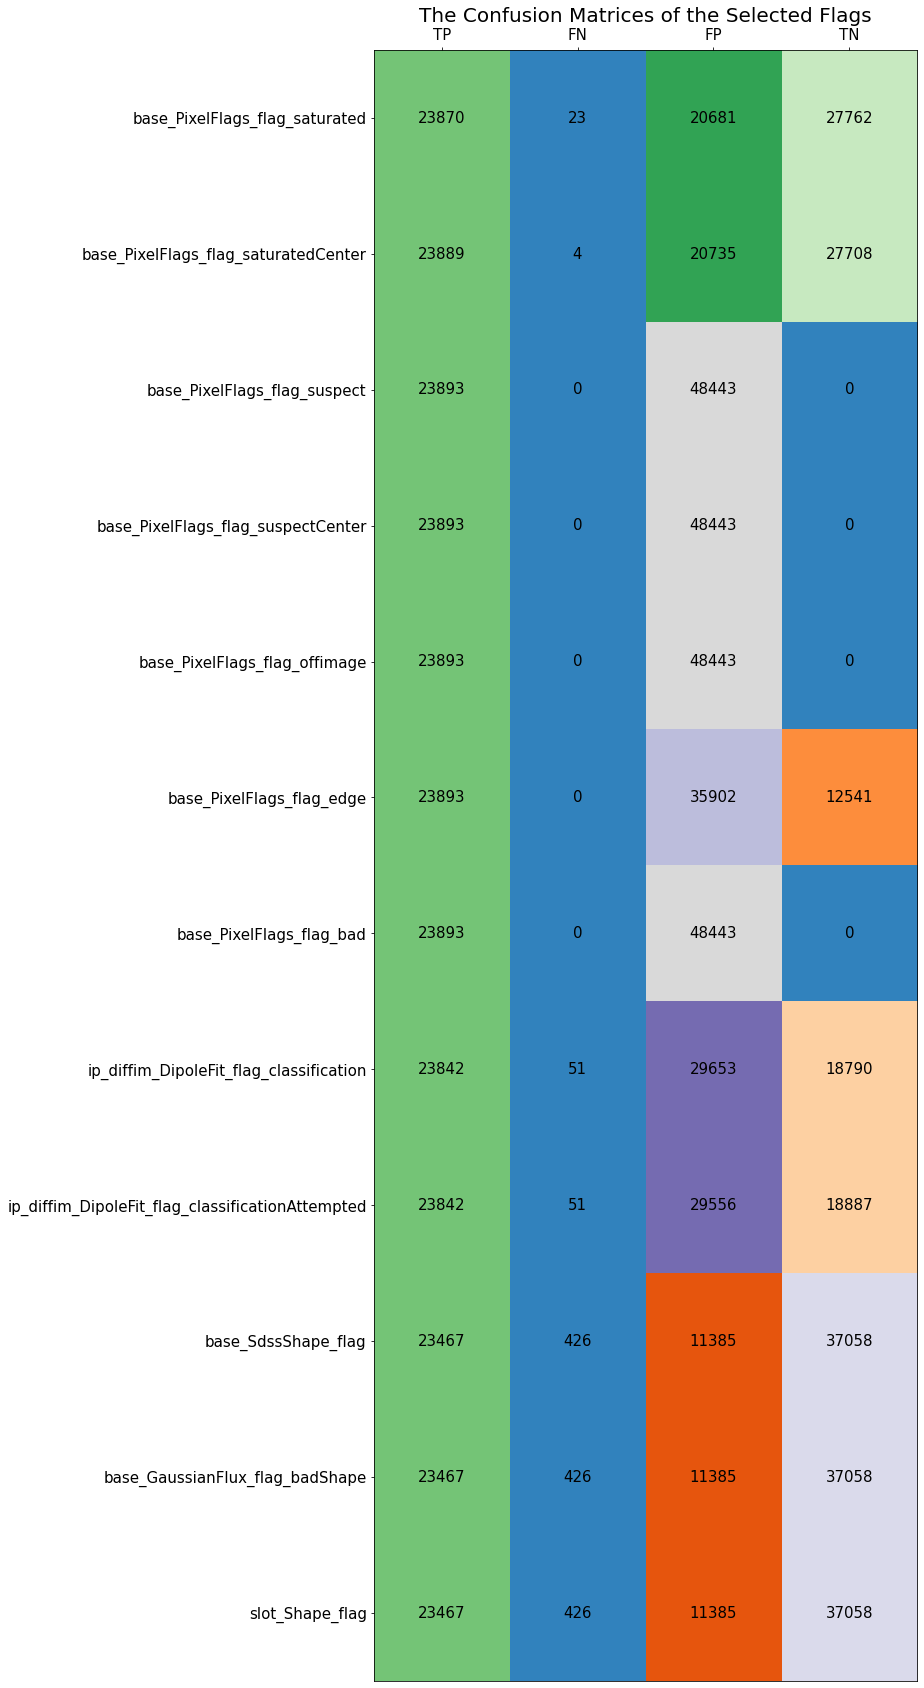

In [ ]:

confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, FLAG_LIST)
plot_confusion_matrix(confusion_matrix, flag_list, 'The Confusion Matrices of the Selected Flags', figsize=(30,30))

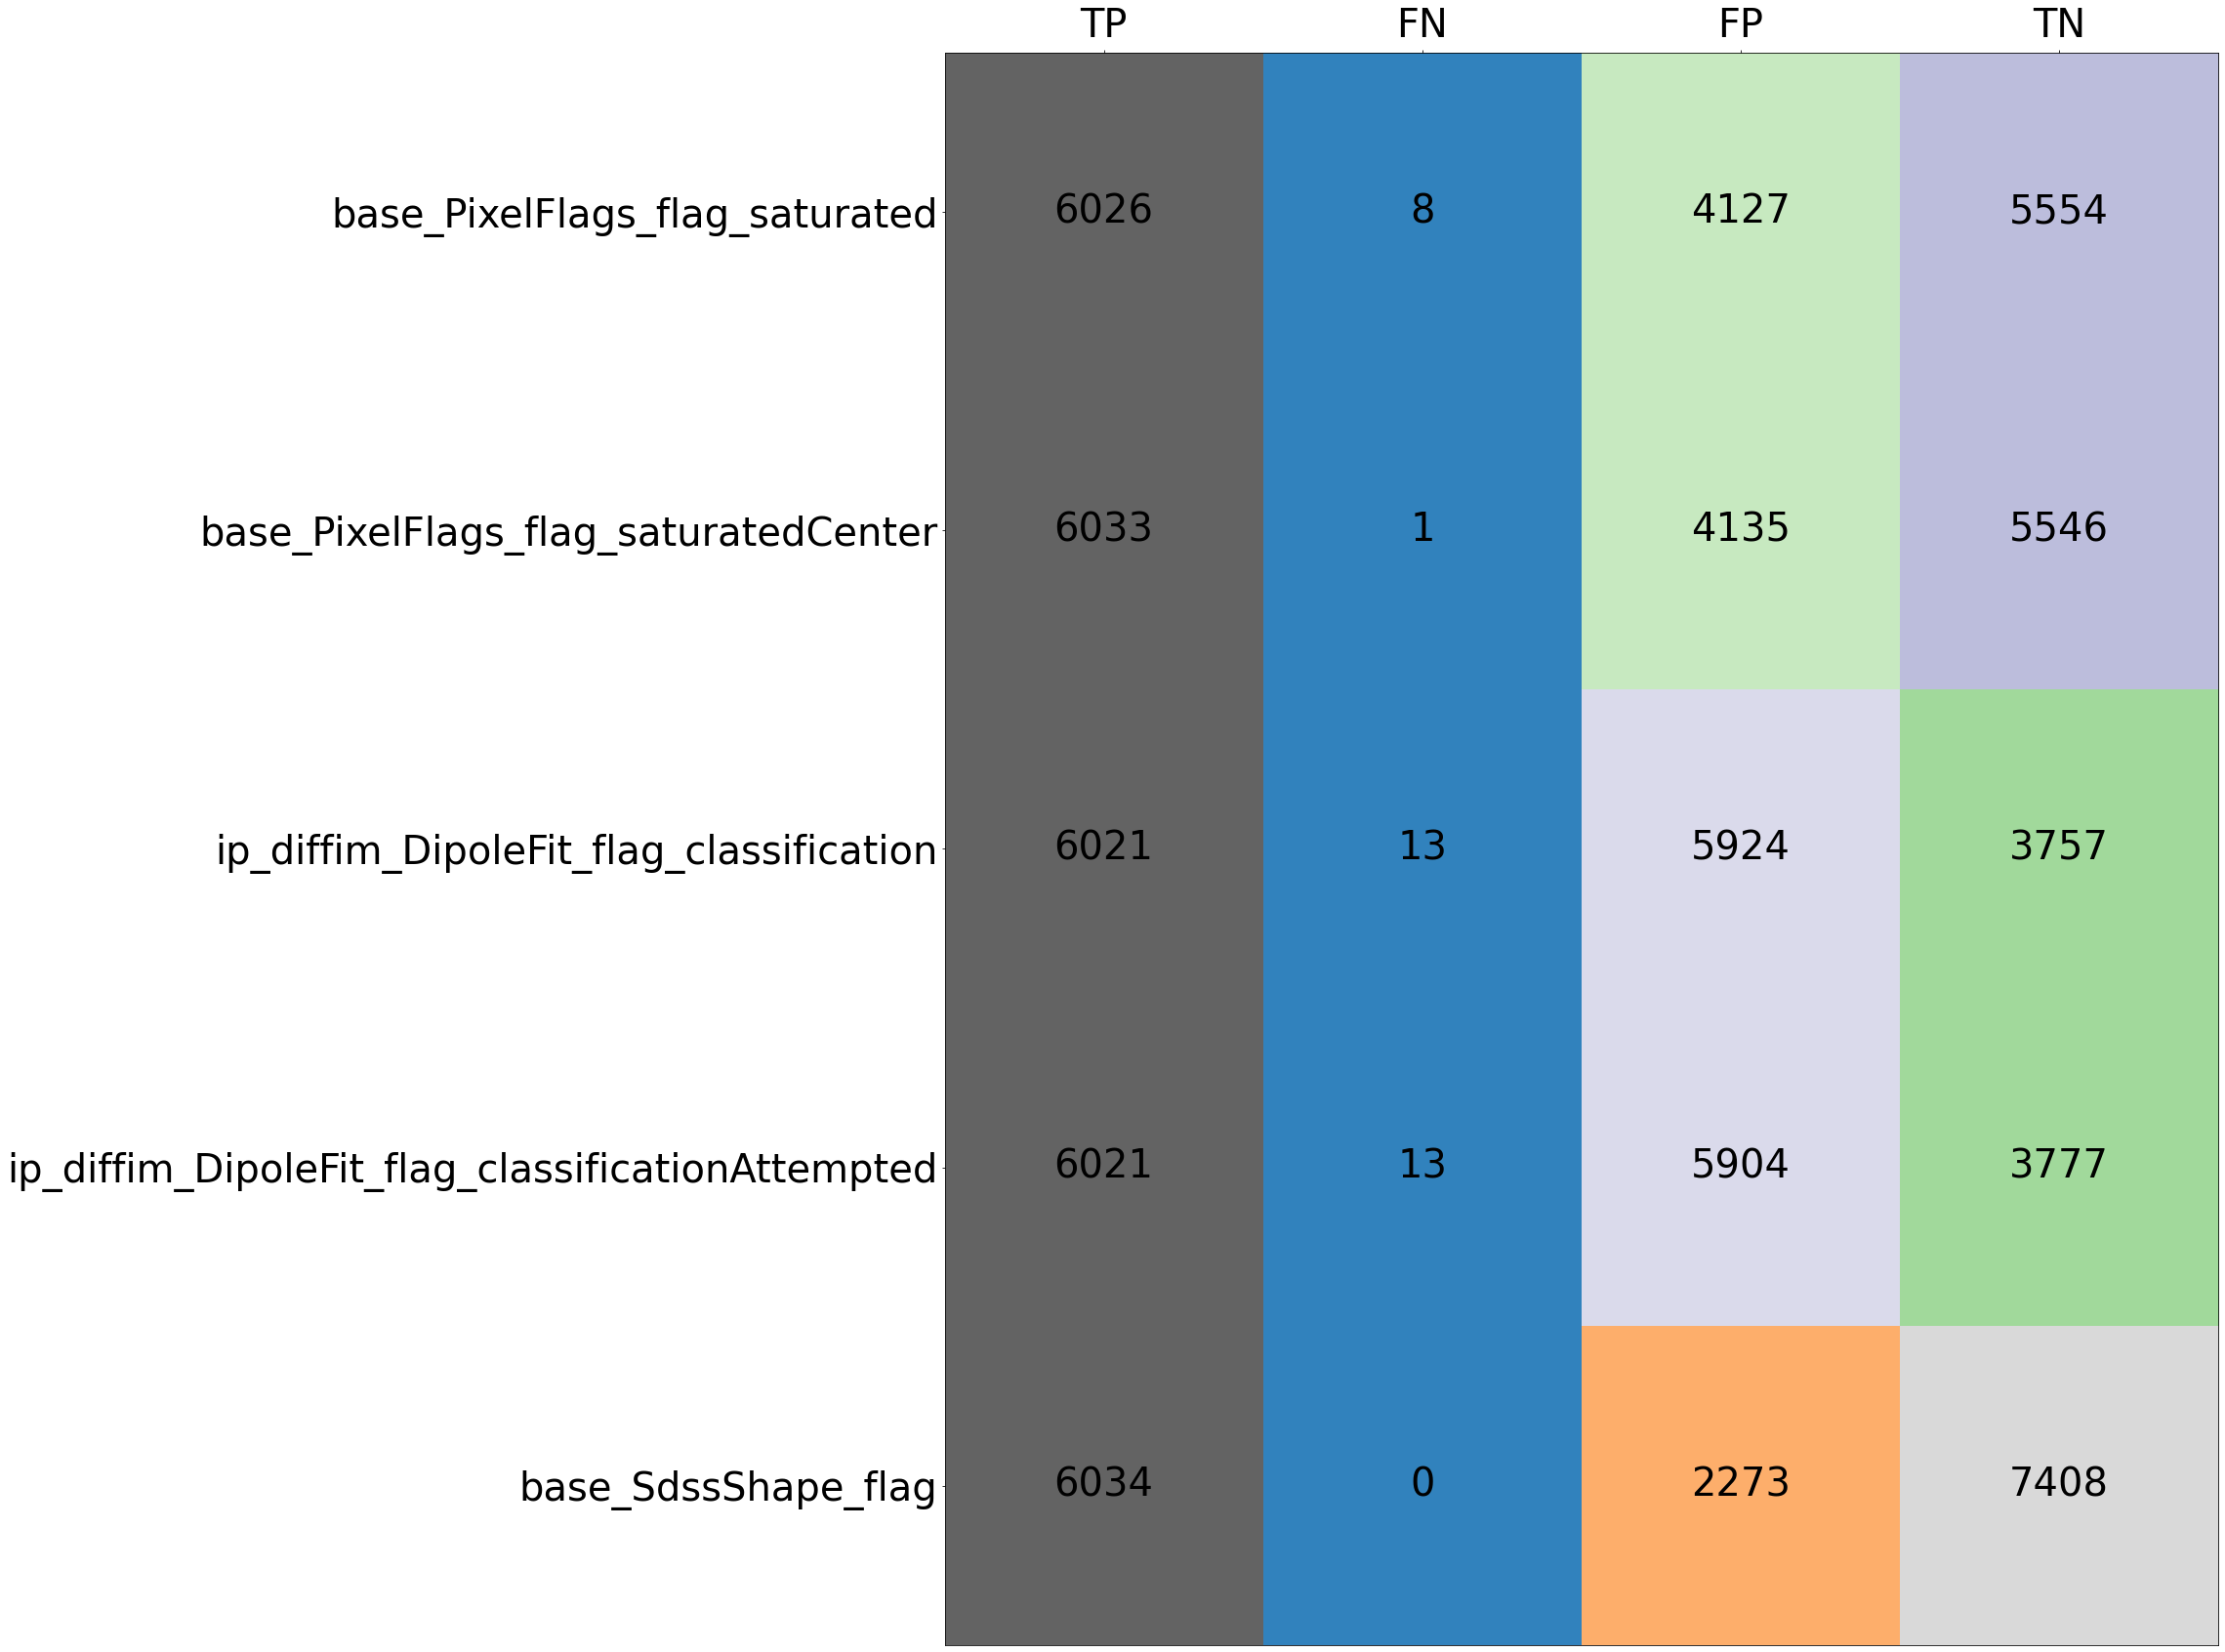

In [ ]:
def plot_confusion_matrix(confusion_matrix, flag_list, title, figsize=(10, 10)):
    x_labels = ['TP', 'FN', 'FP', 'TN']
    y_labels = flag_list
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    im = ax.imshow(confusion_matrix, cmap='tab20c')

    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels, size=40)
    ax.set_yticklabels(y_labels, size=40)
    

    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, confusion_matrix[i, j],
                           ha="center", va="center", color="k", size=40)
    ax.set_title(title, size=40)
    ax.xaxis.tick_top()
FLAG_LIST = [
    'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
    'ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted',
    'base_SdssShape_flag'
]


confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, FLAG_LIST)
plot_confusion_matrix(confusion_matrix, flag_list, None, figsize=(30,30))
plt.savefig('flag_selected.png', dpi=100)

In [ ]:
flag_col = []
for i in flux.columns:
    if re.search('flag', i):
        flag_col.append(i)

In [ ]:
len(flag_list)

12

In [ ]:
len(flag_col)

109

In [ ]:
flag_slice_list = []
for i in range(11):
    print(i*10, i*10 + 10)
    if i == 10:
        flag_slice = flag_col[i*10:]
        print(len(flag_slice))
    else:
        flag_slice = flag_col[i*10:i*10+10]
        
    flag_slice_list.append(flag_slice)


0 10
10 20
20 30
30 40
40 50
50 60
60 70
70 80
80 90
90 100
100 110
9


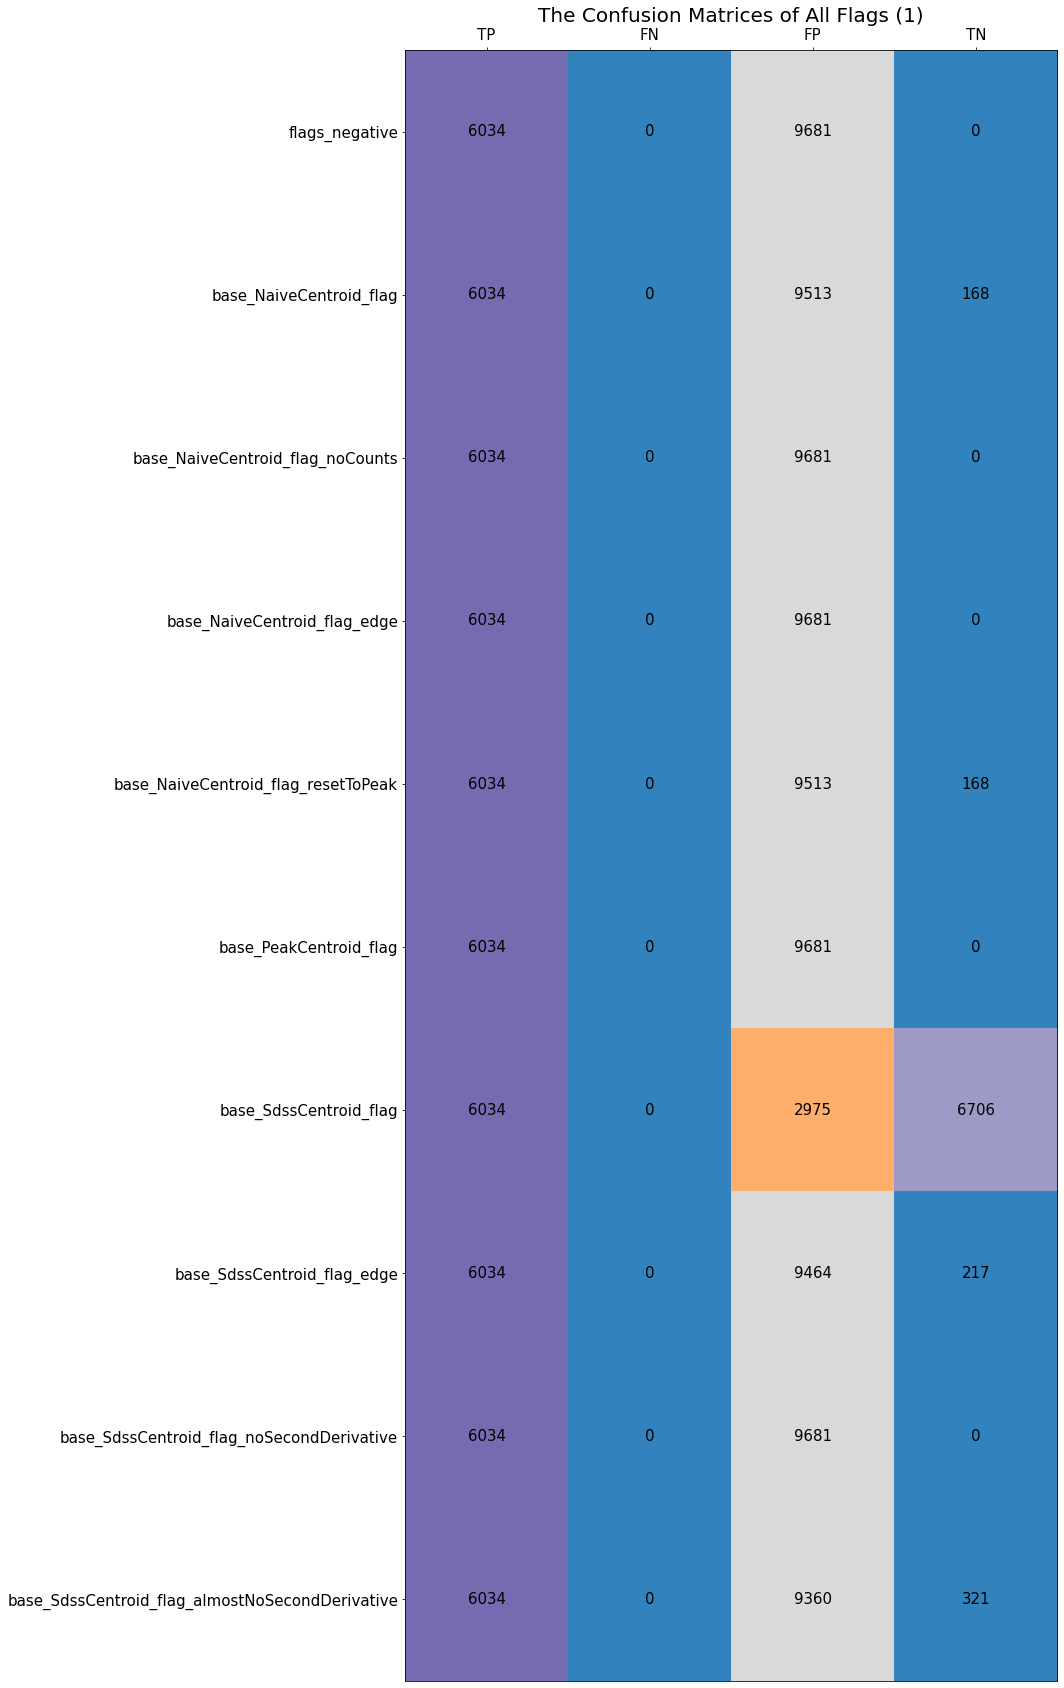

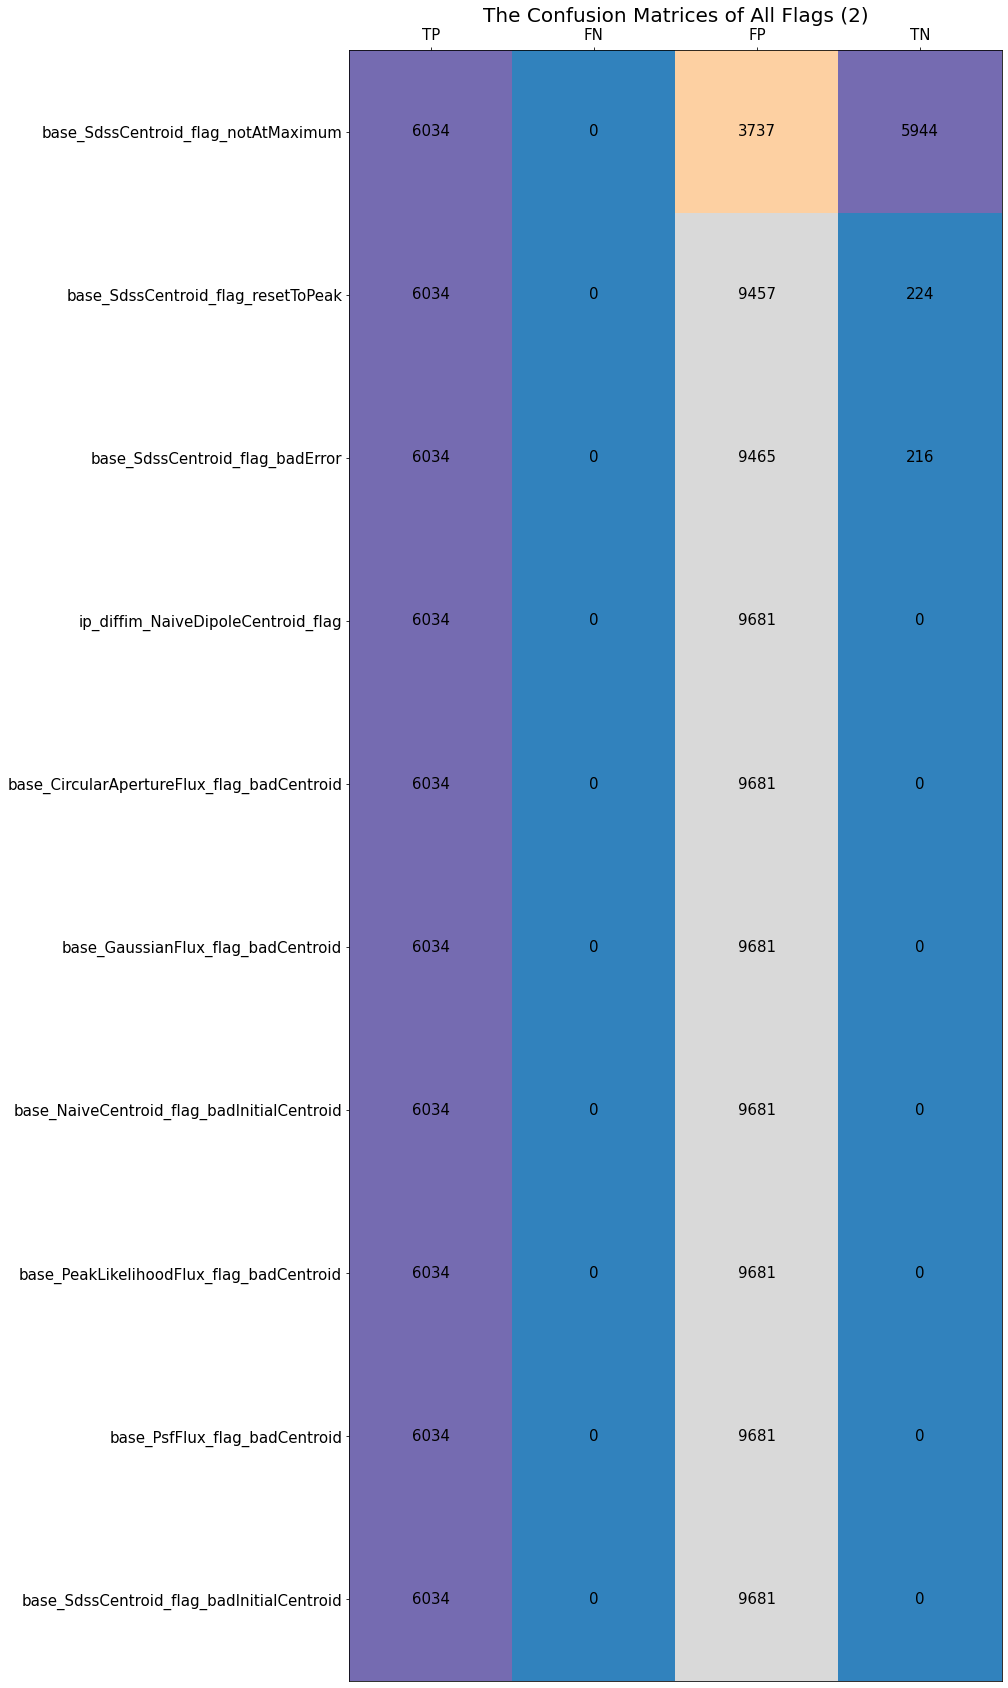

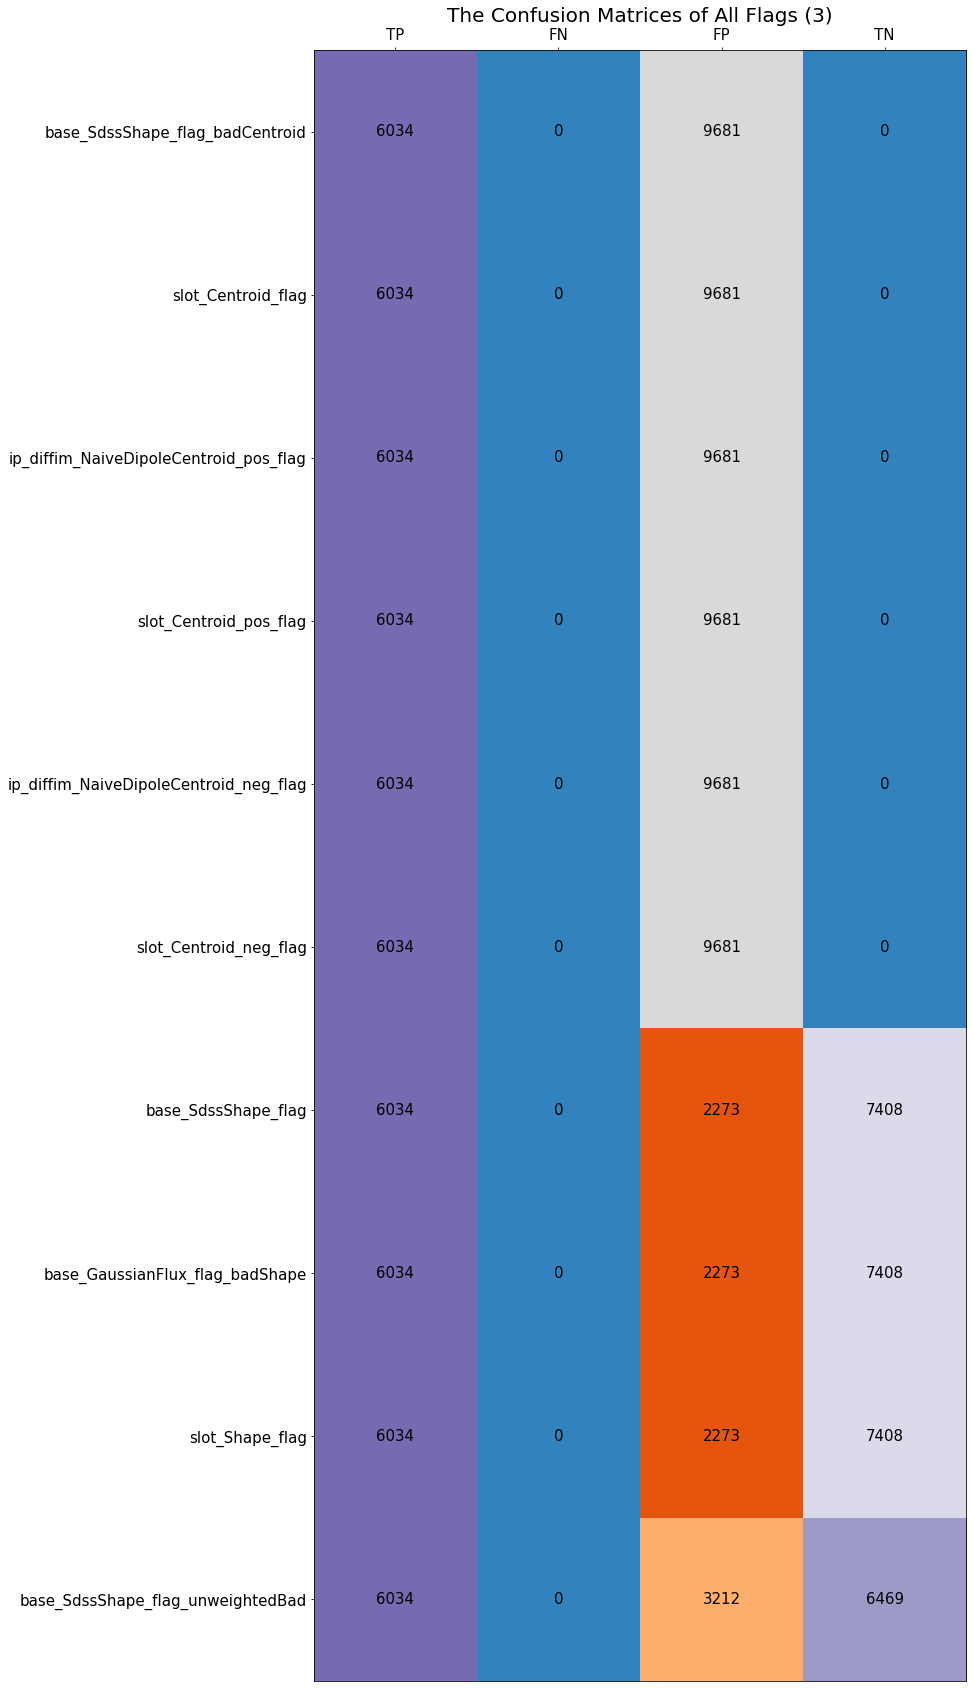

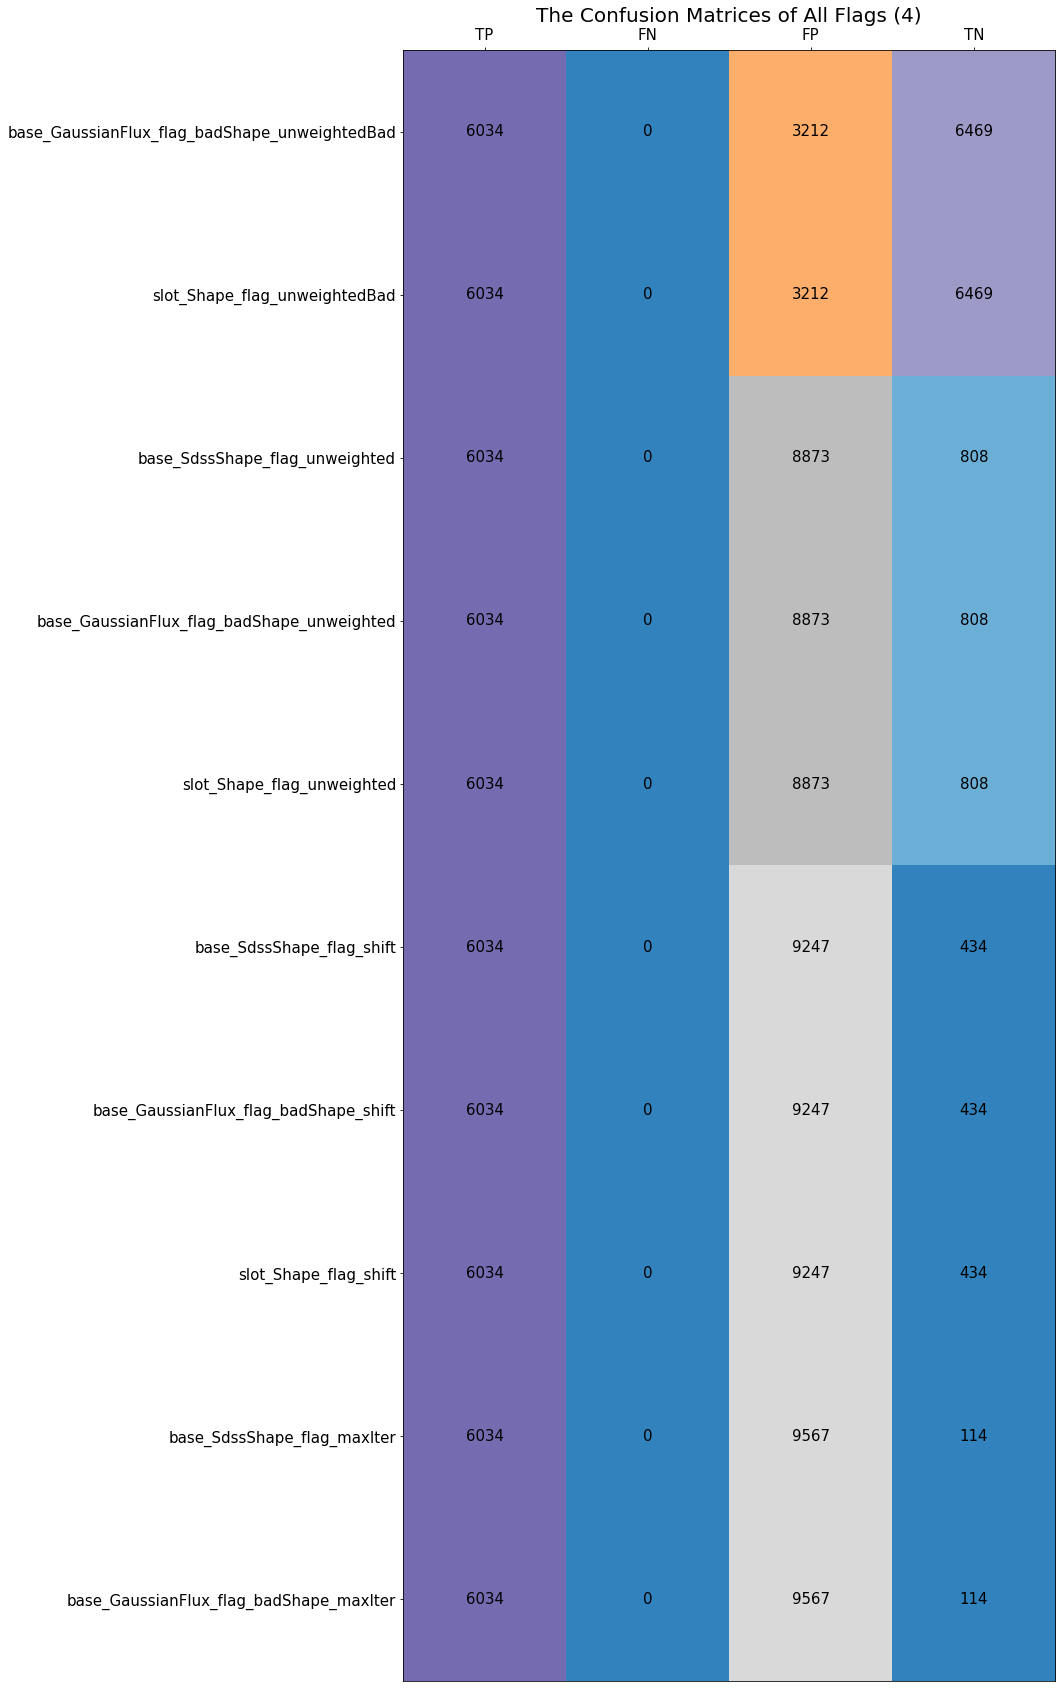

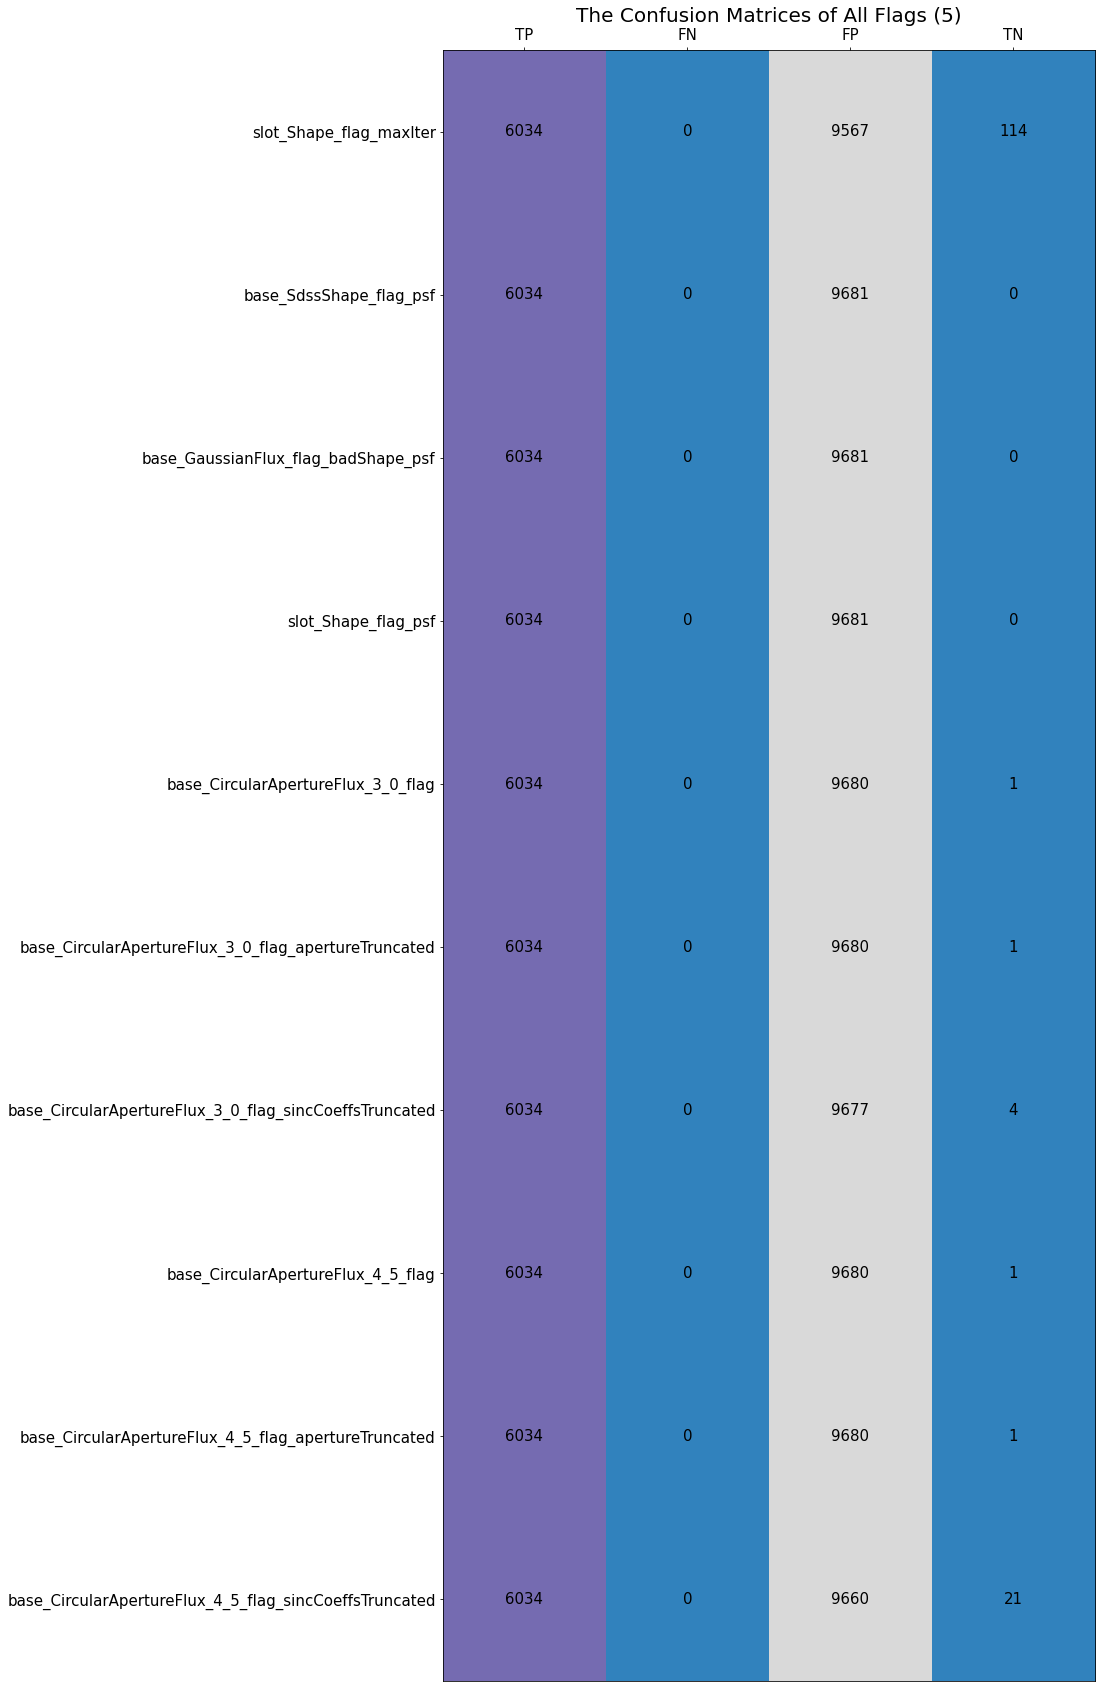

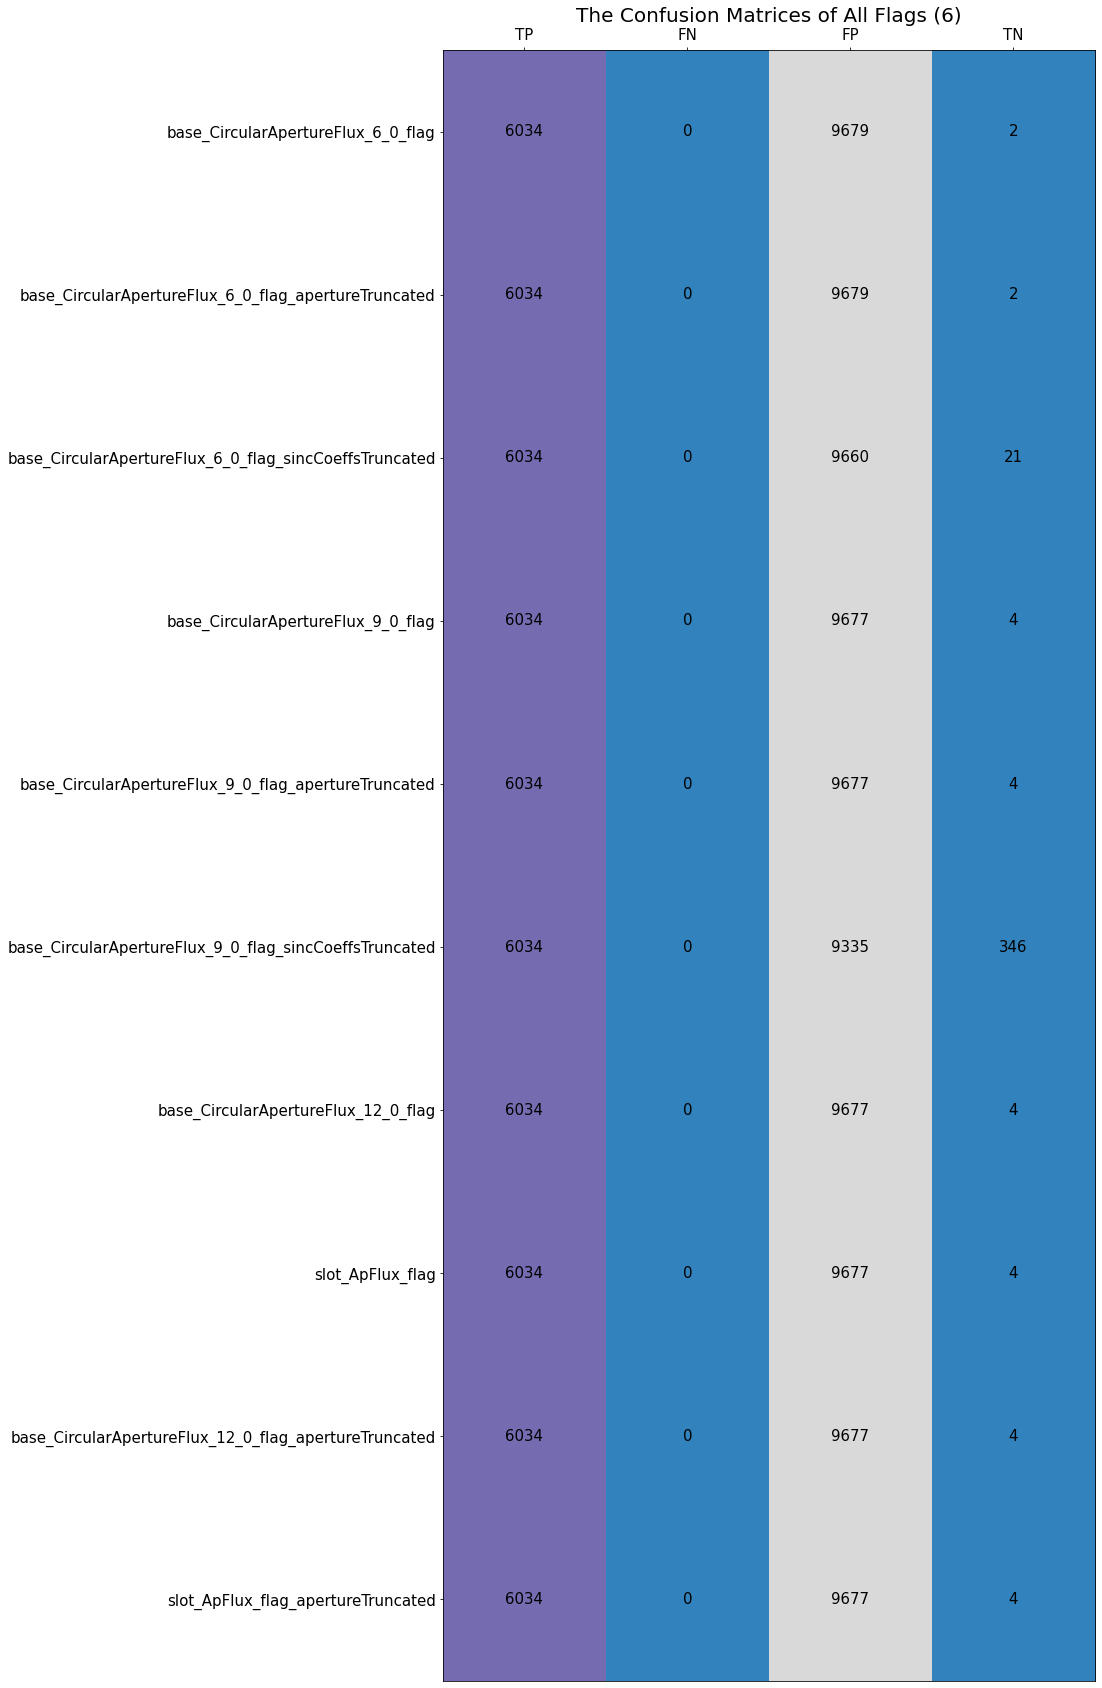

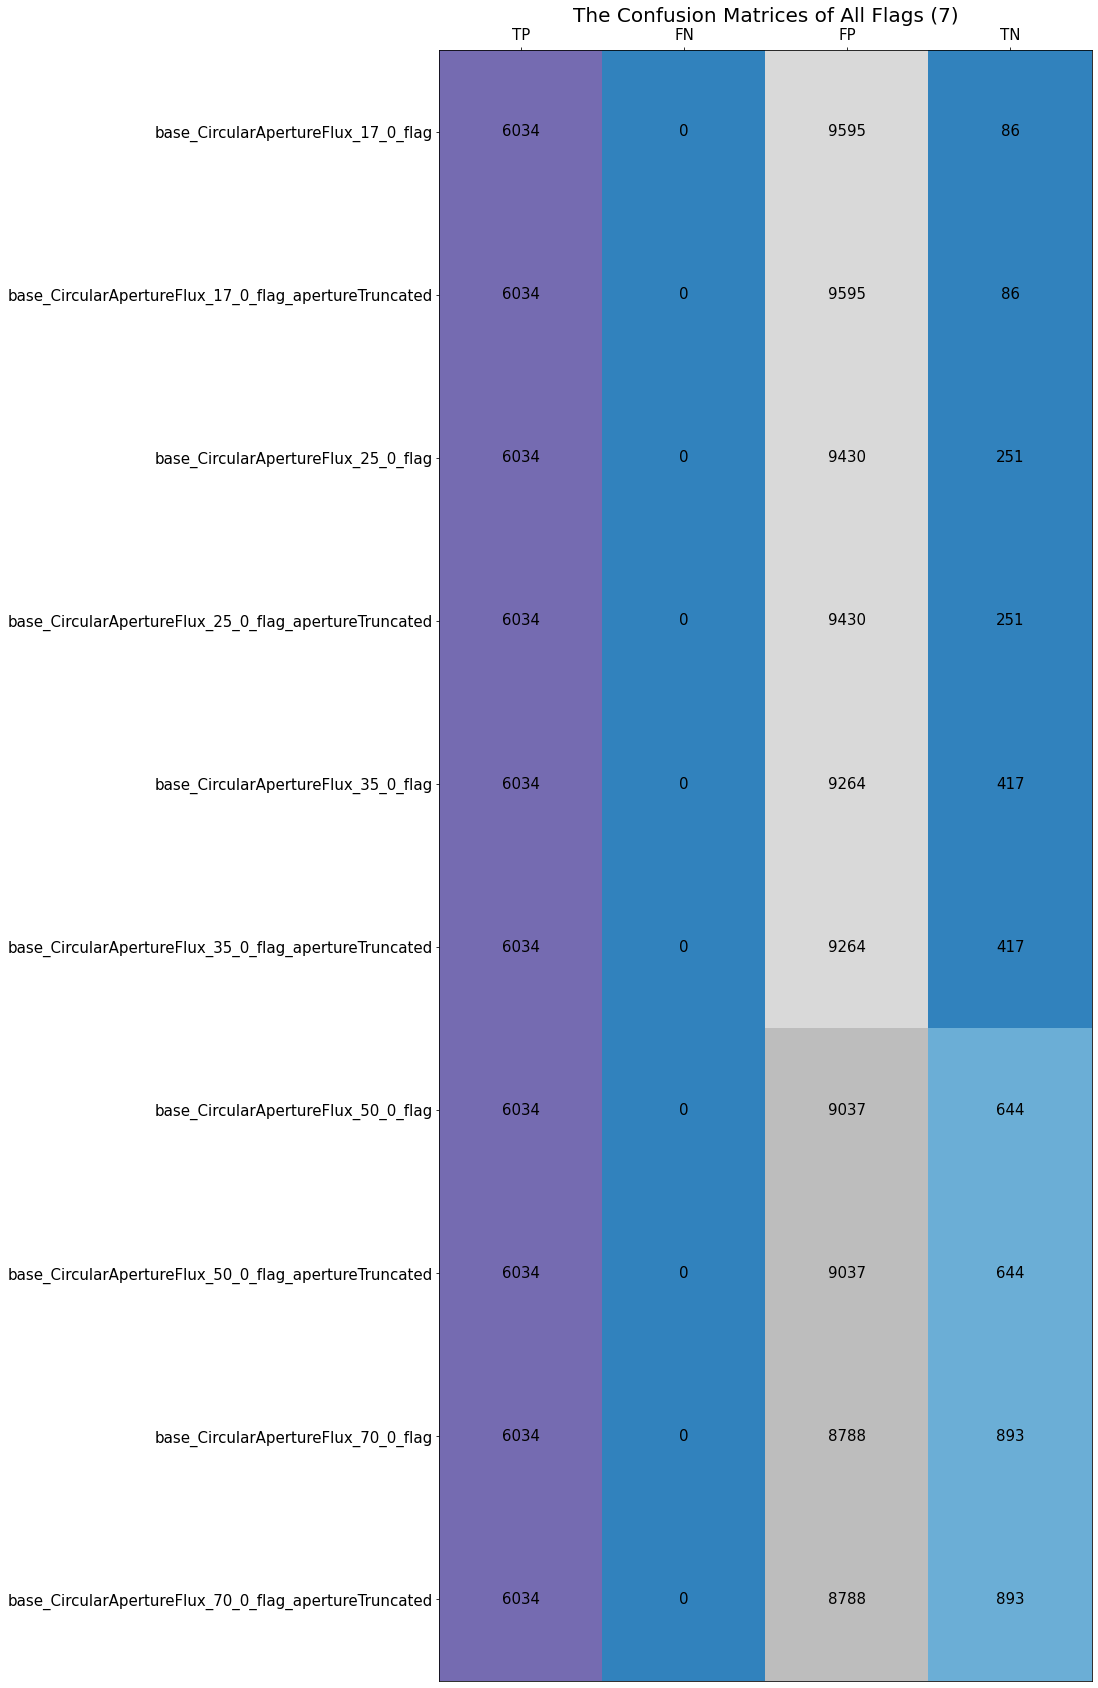

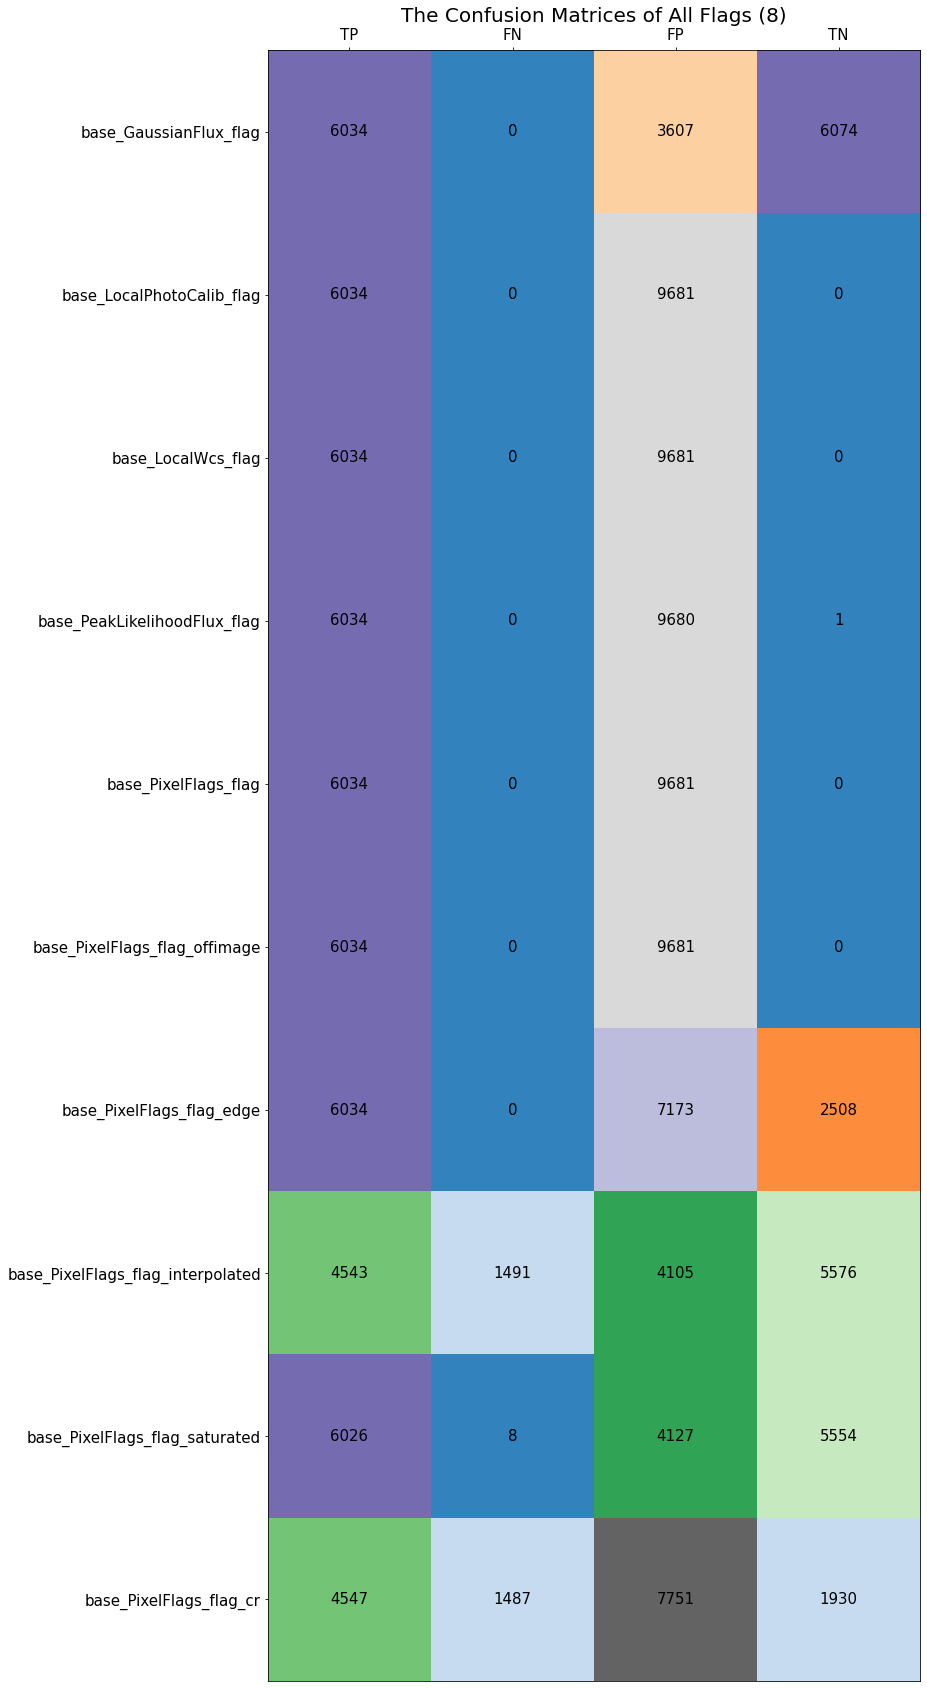

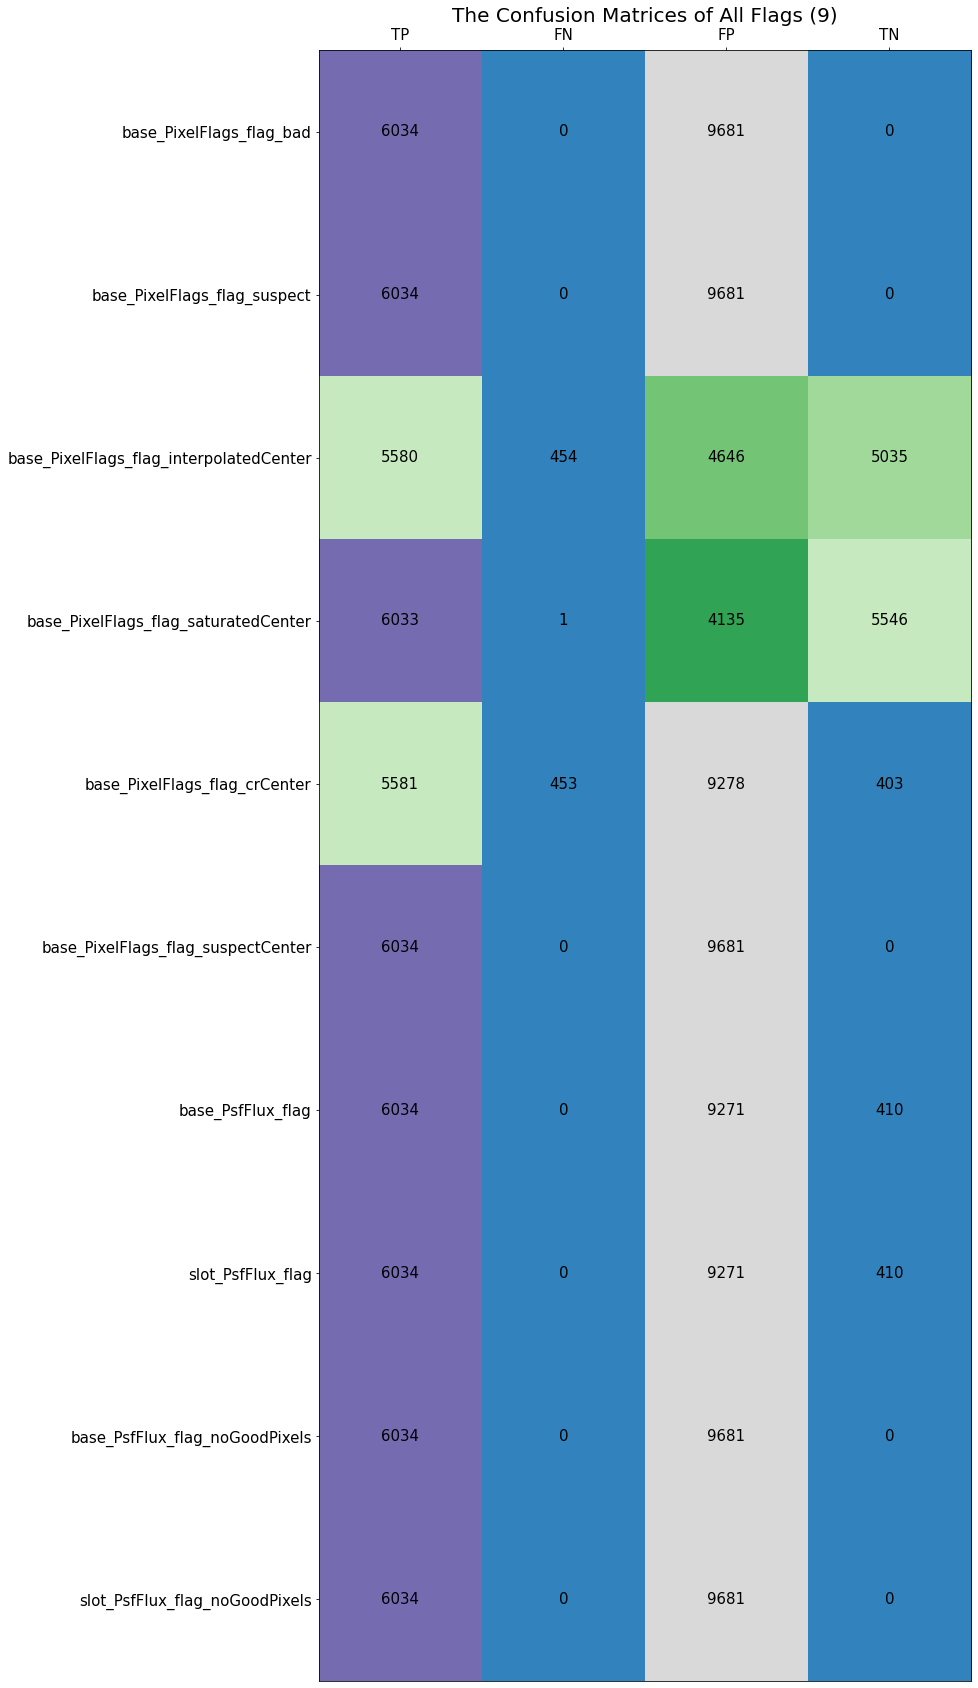

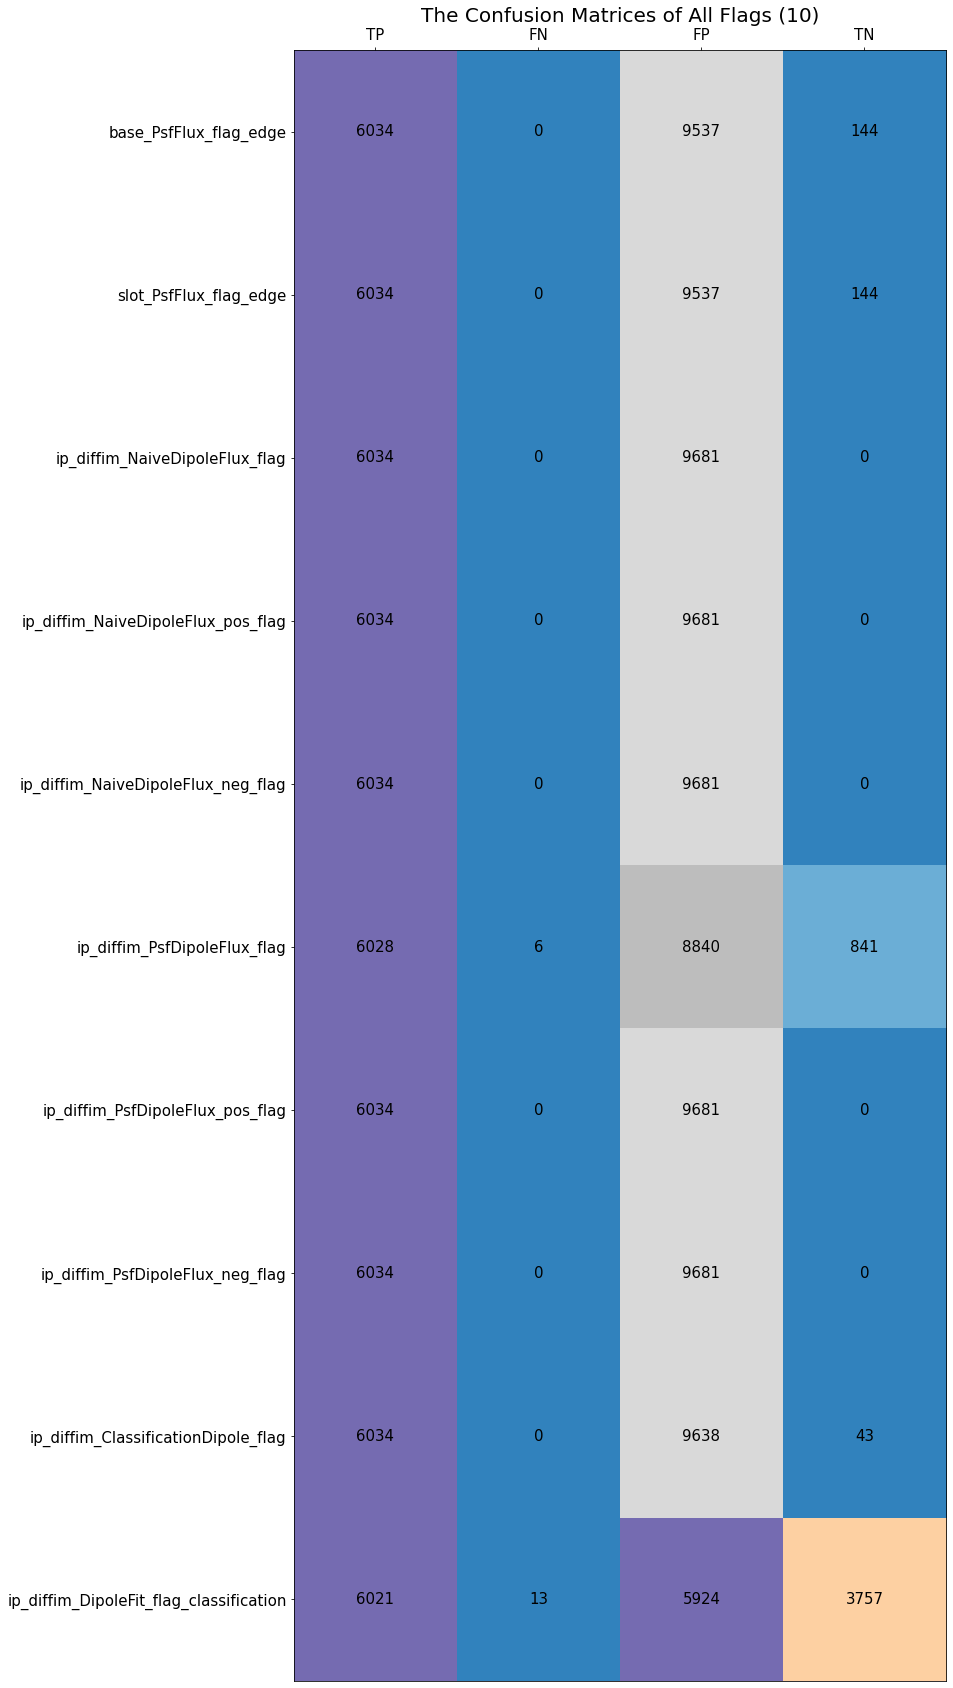

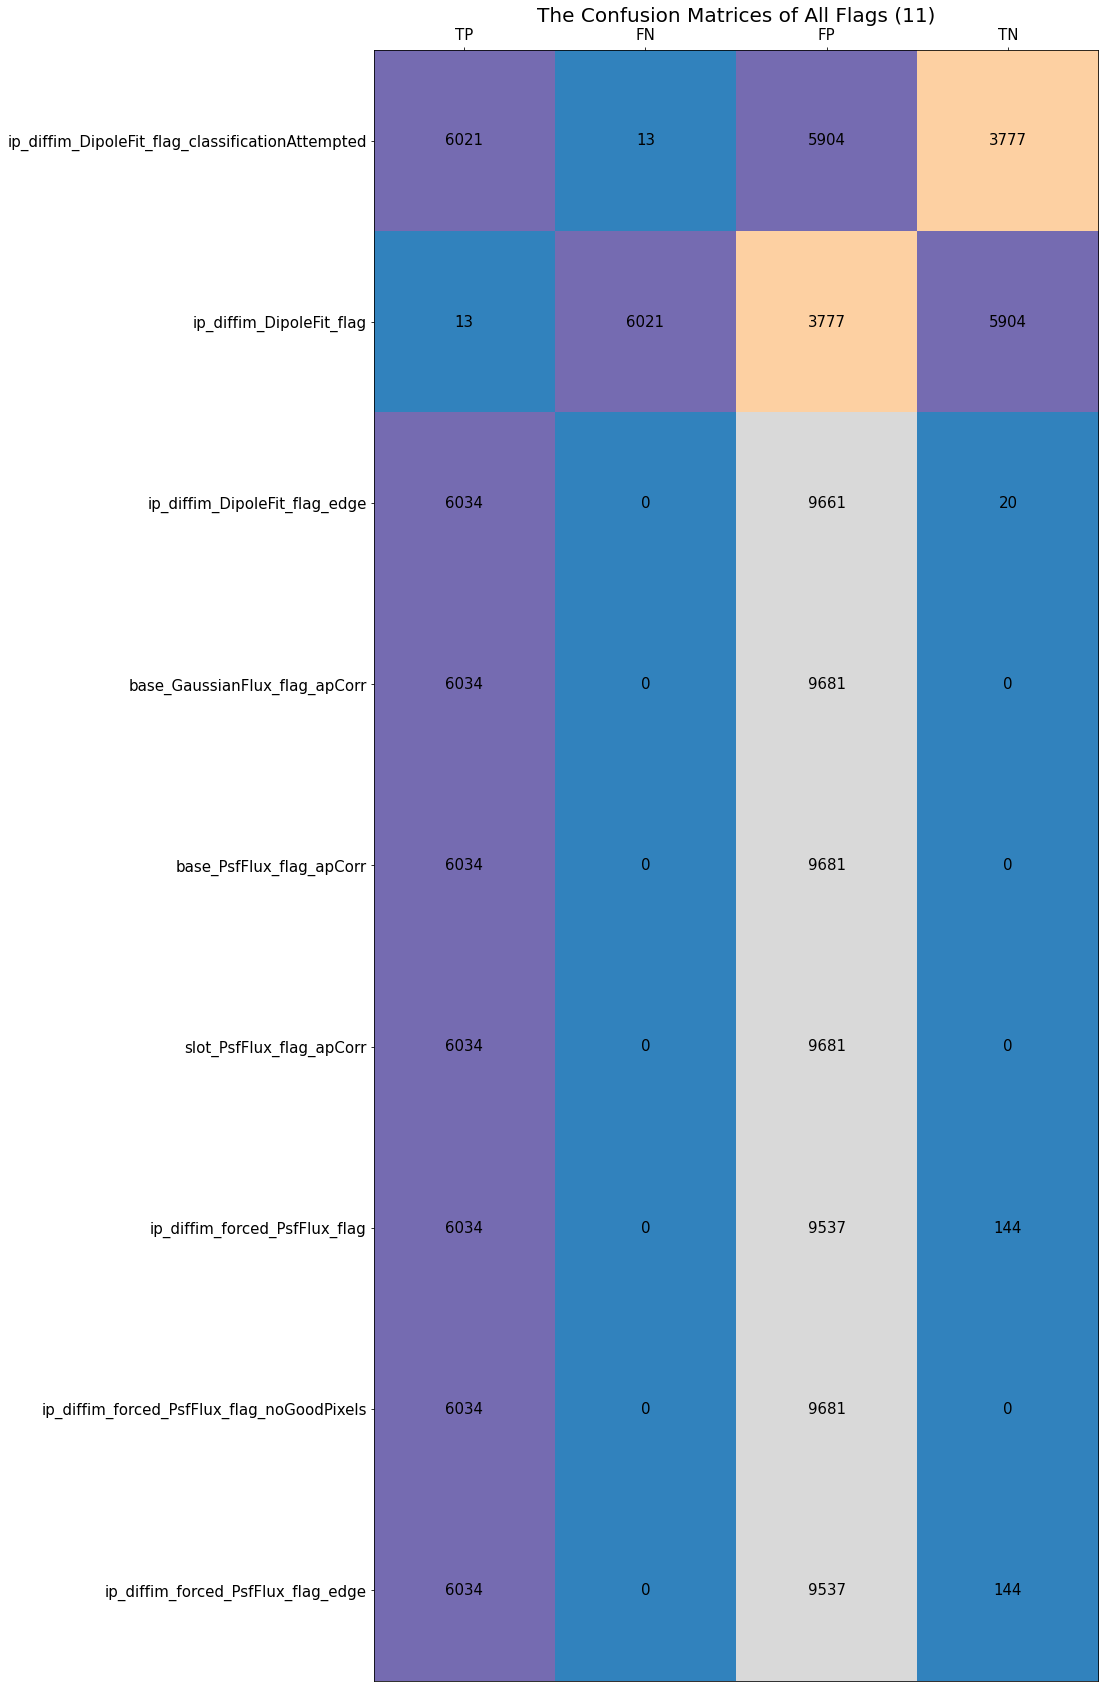

In [ ]:
for i, flag_slice in enumerate(flag_slice_list):
    confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, flag_slice)
    plot_confusion_matrix(confusion_matrix, flag_list, f'The Confusion Matrices of All Flags ({i+1})', figsize=(30,30))
    plt.savefig(f'plot_flag_{i+1}.png', dpi=100)
    

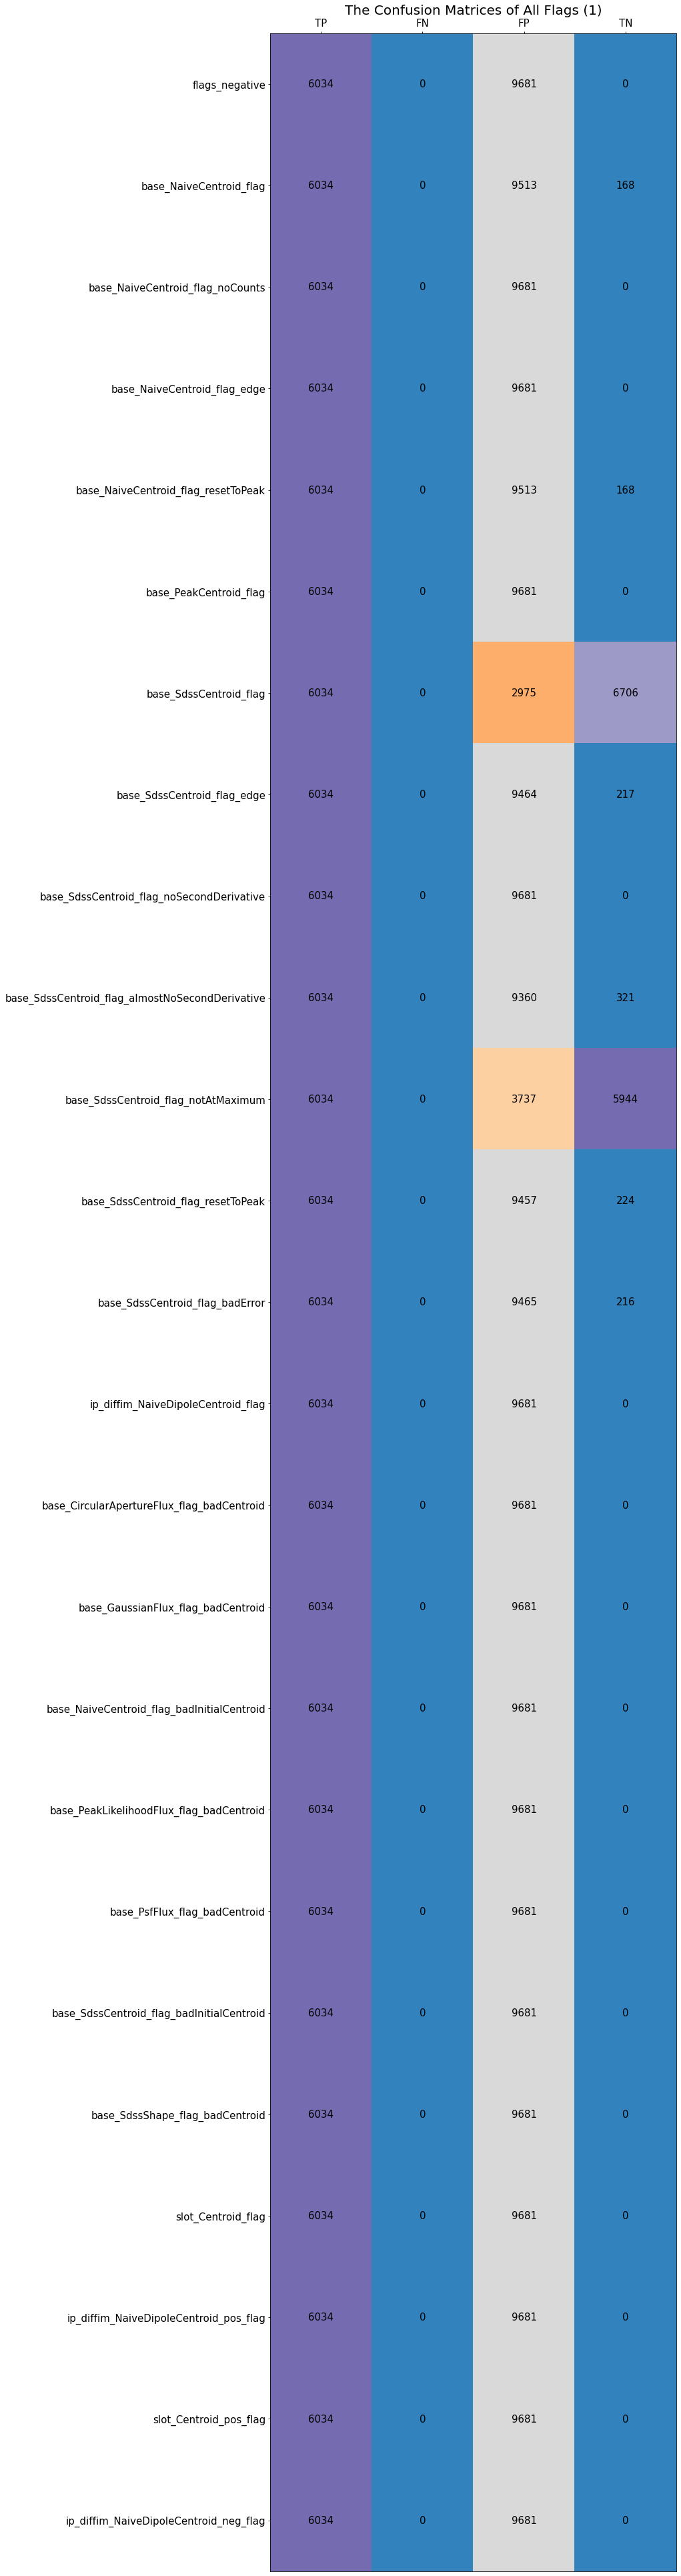

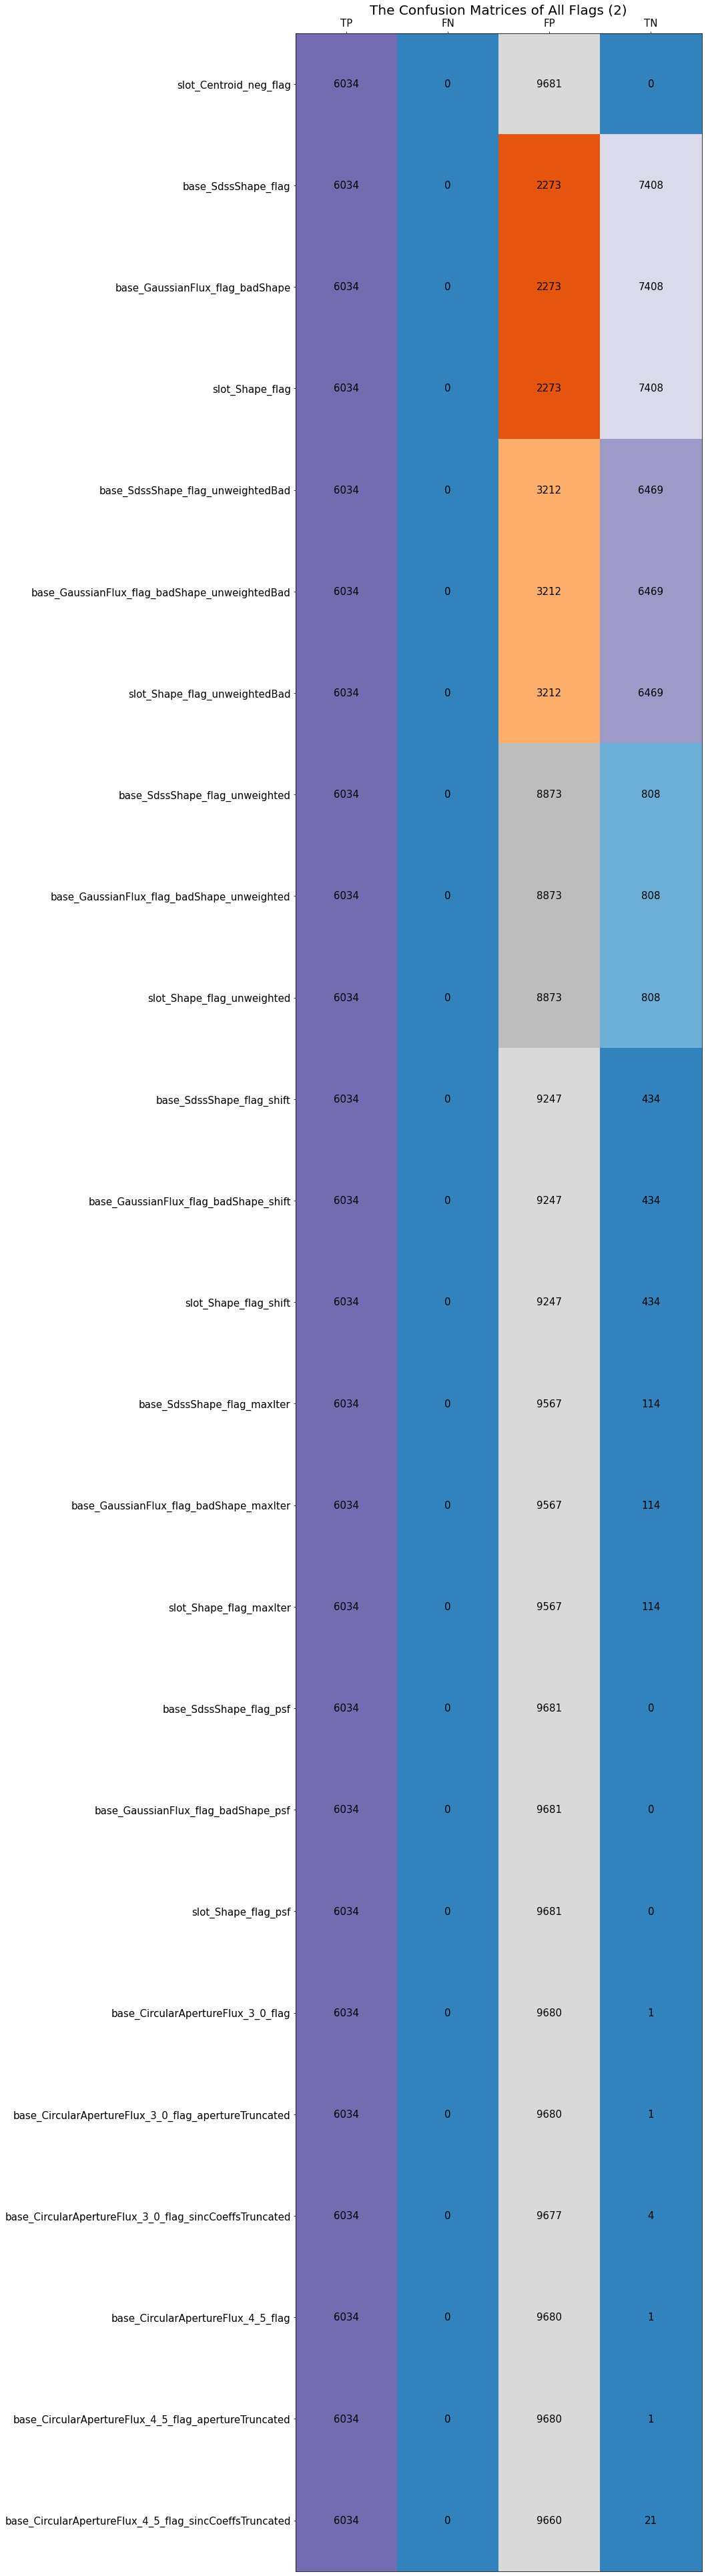

In [ ]:
confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, flag_col_2)
plot_confusion_matrix(confusion_matrix, flag_list, 'The Confusion Matrices of All Flags (2)', figsize=(70,70))
plt.savefig('flag_2.png', dpi=100)

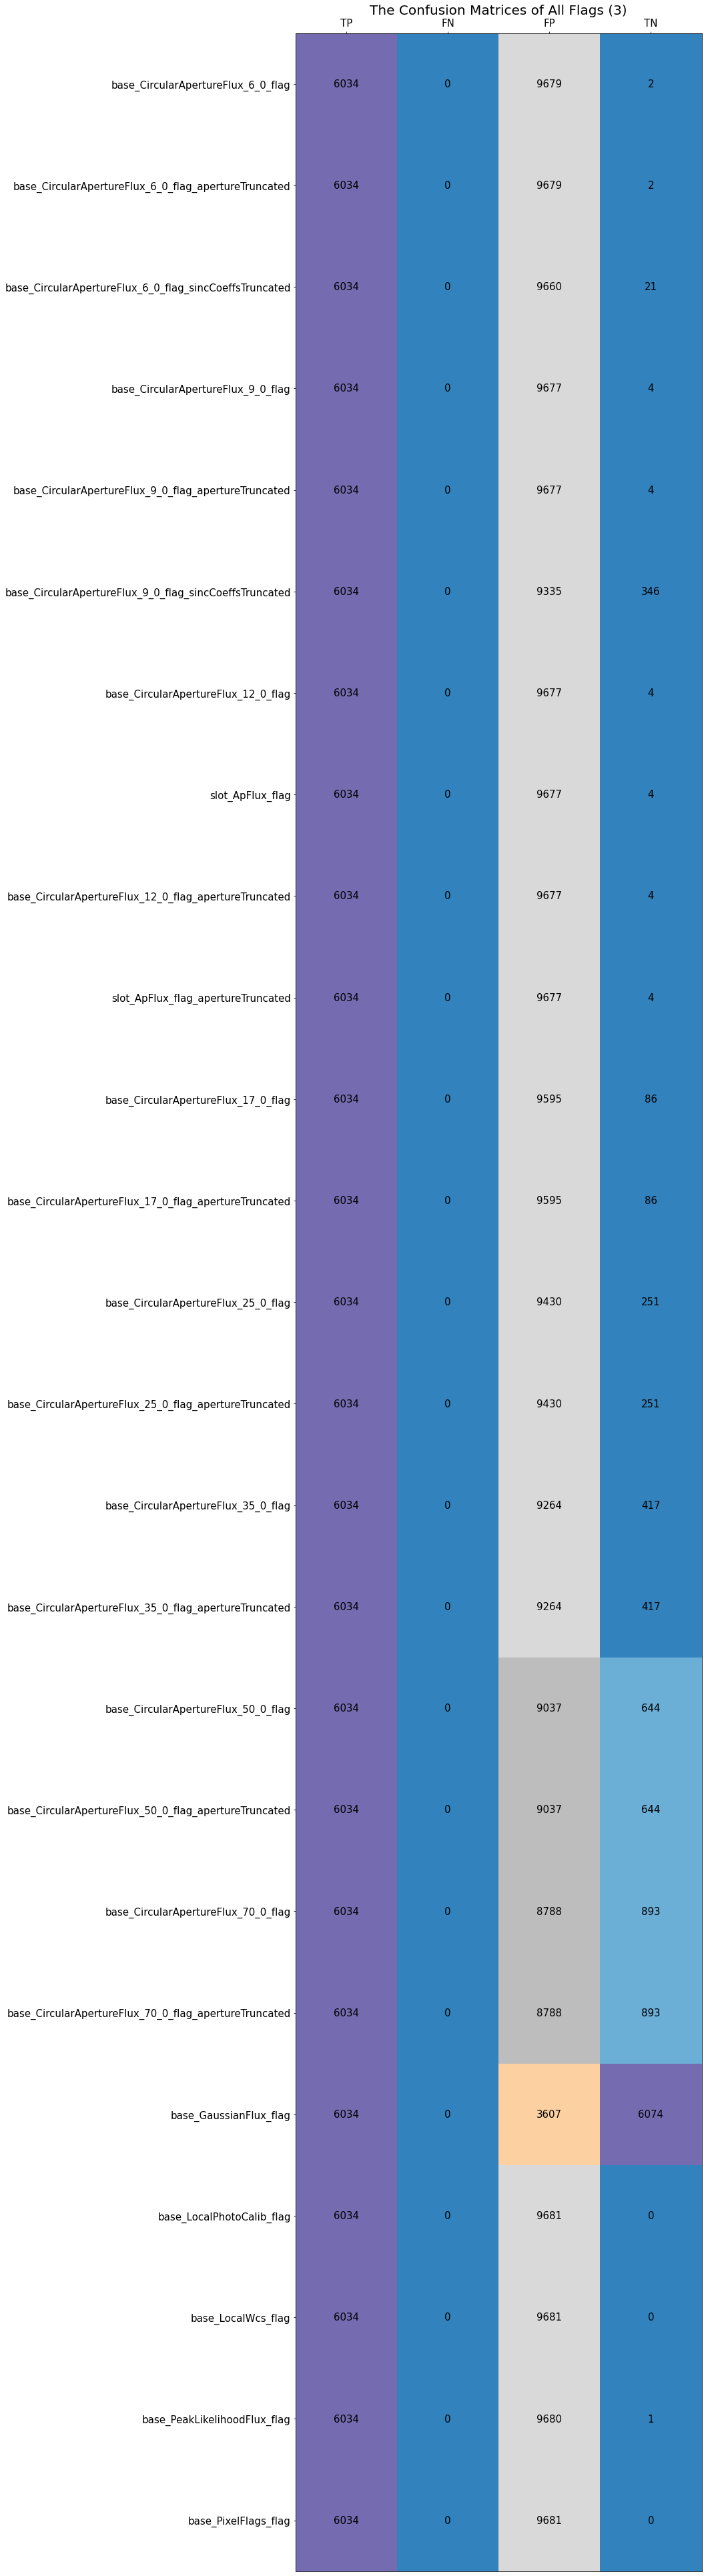

In [ ]:
confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, flag_col_3)
plot_confusion_matrix(confusion_matrix, flag_list, 'The Confusion Matrices of All Flags (3)', figsize=(70,70))
plt.savefig('flag_3.png', dpi=100)

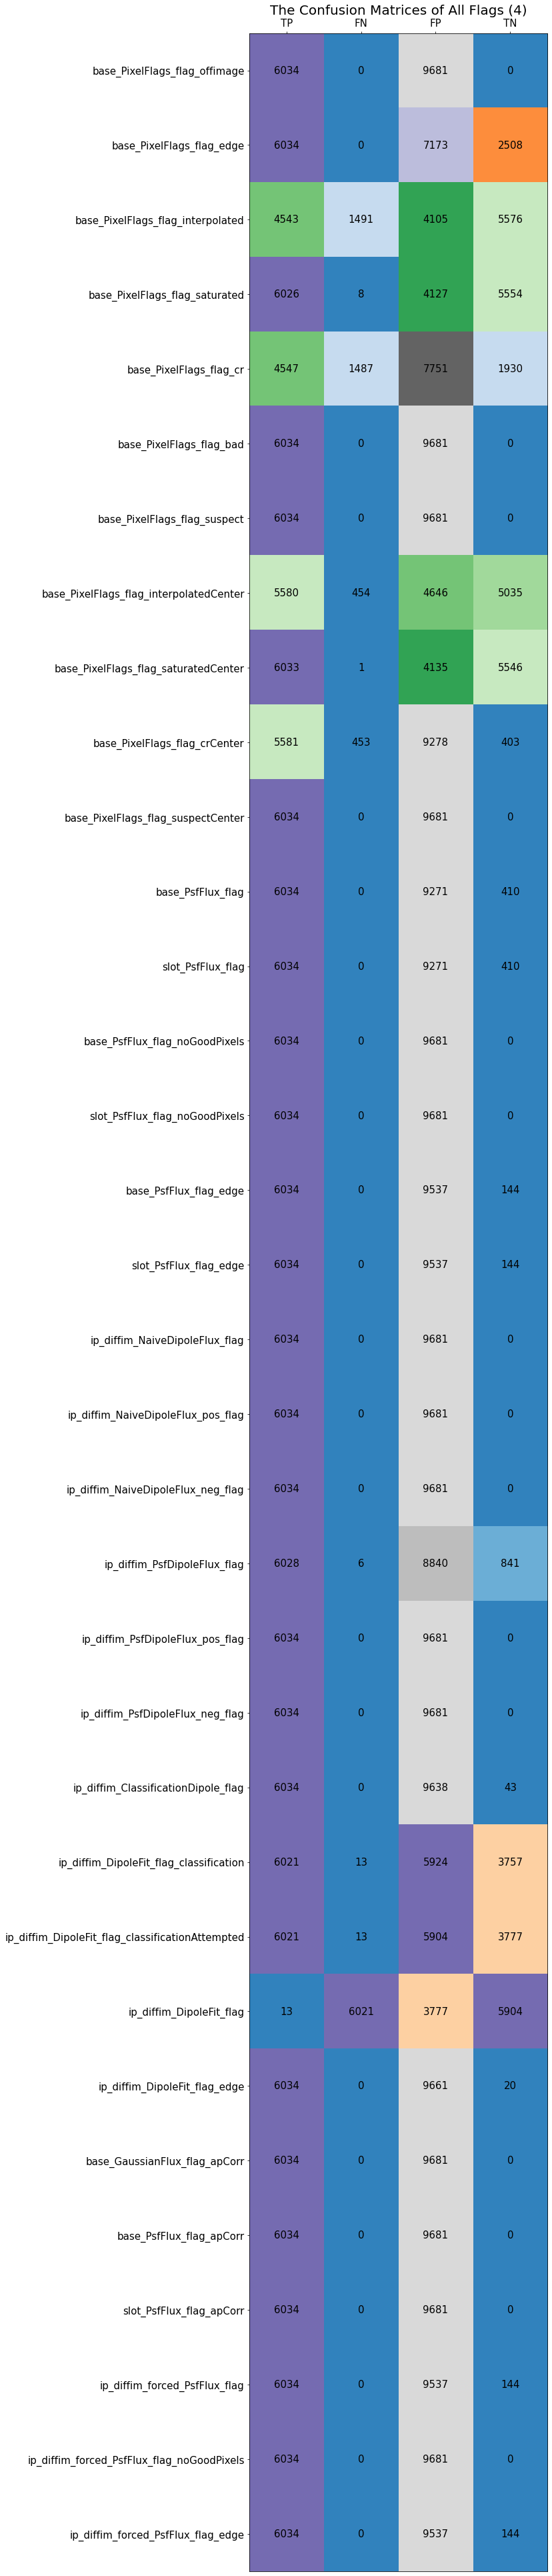

In [ ]:
confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, flag_col_4)
plot_confusion_matrix(confusion_matrix, flag_list, 'The Confusion Matrices of All Flags (4)', figsize=(70,70))
plt.savefig('flag_4.png', dpi=100)

In [ ]:
'base_SdssShape_flag'

'base_SdssShape_flag'

In [ ]:
def remove_flag(df, flag):
    keep_id = (df[flag] == 0).to_numpy()
    new_df = df.loc[keep_id].copy().reset_index(drop=True)
    return new_df
    
def remove_flags(src_df, flag_list=None):
    flags = src_df.loc[:, flag_list].copy().reset_index(drop=True)
    keep_id = (flags.sum(axis=1) == 0).to_numpy()
    return src_df[keep_id].copy().reset_index(drop=True)

# Base Flag

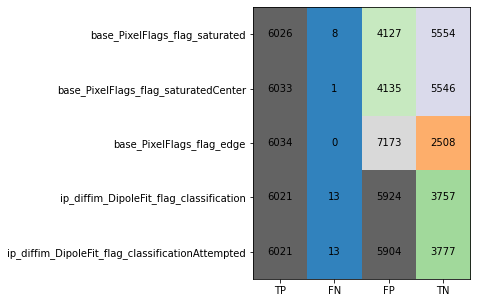

In [14]:
FLAG_LIST = [
    'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
    'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_suspectCenter',
    'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge','base_PixelFlags_flag_bad',
    'ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']


confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, FLAG_LIST)
plot_confusion_matrix(confusion_matrix, flag_list, figsize=(10,5))


- 'base_PixelFlags_flag_suspect'
- 'base_PixelFlags_flag_suspectCenter',
- 'base_PixelFlags_flag_offimage'
- 'base_PixelFlags_flag_bad'

are not flagged in the diaSrc table, even though they seems useful.

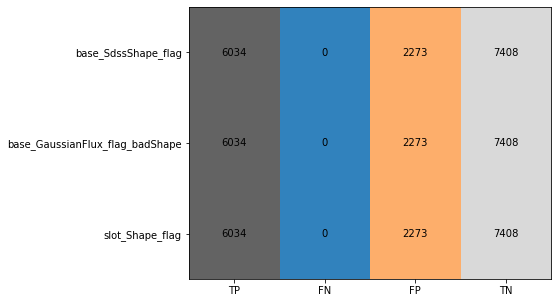

In [34]:
FLAG_LIST = [ 'base_SdssShape_flag', 'base_GaussianFlux_flag_badShape', 'slot_Shape_flag']

confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, FLAG_LIST)
plot_confusion_matrix(confusion_matrix, flag_list, figsize=(10,5))




what is base_SdssShape_flag? slot_Shape_flag is a pointer?

# apply flags

after applying 
| base_PixelFlags_flag_saturated         | base_PixelFlags_flag_saturatedCenter |
|ip_diffim_DipoleFit_flag_classification | base_PixelFlags_flag_edge            |
|slot_flag |

reduce ,


we get:

efficiency: 99.7%
purity: 71.1%

               predicted fake | predicted artifacts
true fake      |    TP: 6013      |     FN: 21

true artifact  |    FP: 2442       |     TN: 7239


after applying  base_SdssShape_flag:  false positive 2442 -> 828
we have

efficiency: 99.7%         
purity: 87.9%

               predicted fake | predicted artifacts
true fake      |    TP: 6013      |     FN: 21

true artifact  |    FP: 828       |     TN: 8853


 


In [30]:
flag_col = []
for i in flux.columns:
    if re.search('flag', i):
        flag_col.append(i)
confusion_matrix, flag_list = get_confusion_matrix(flux_remov, fp_remov, flag_col)
confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, flag_col)
plot_confusion_matrix(confusion_matrix, flag_list)

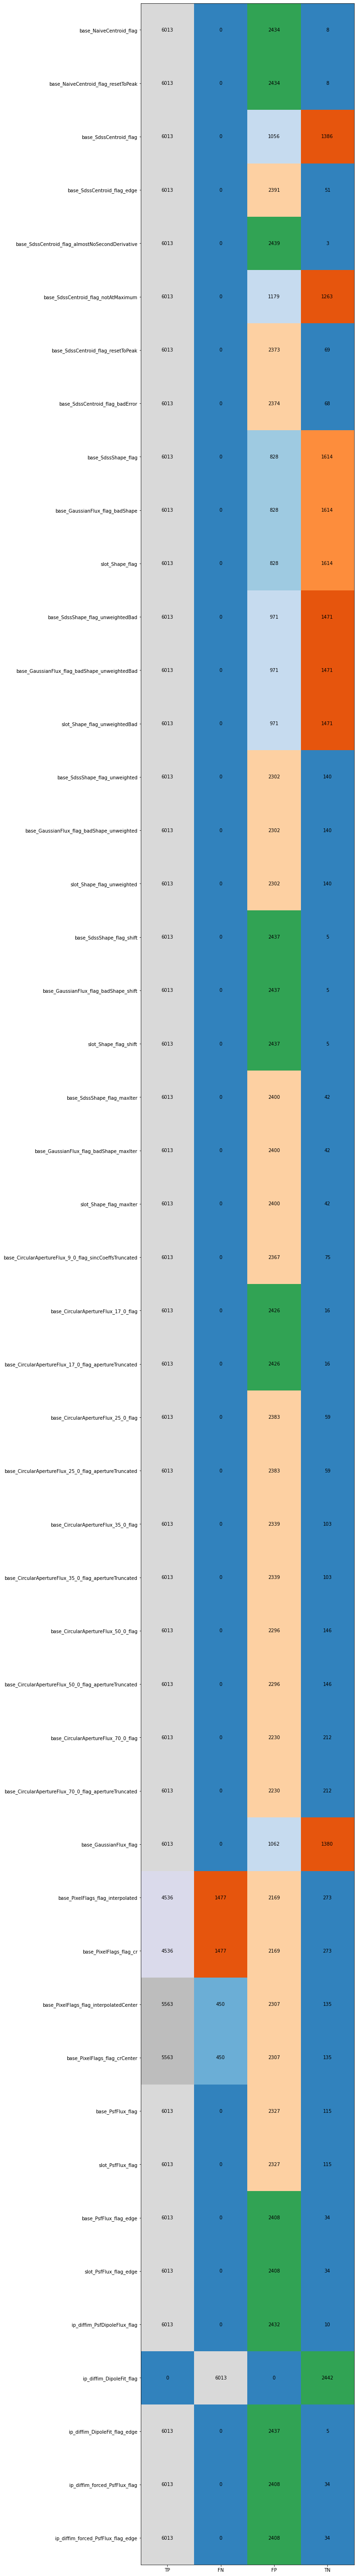

In [33]:
flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
         'ip_diffim_DipoleFit_flag_classification', 'base_PixelFlags_flag_edge']
flux_remov = remove_flags(flux_det, flag_list=flags)
fp_remov = remove_flags(fp, flag_list=flags)
confusion_matrix, flag_list = get_confusion_matrix(flux_remov, fp_remov, flag_col)
plot_confusion_matrix(confusion_matrix, flag_list)

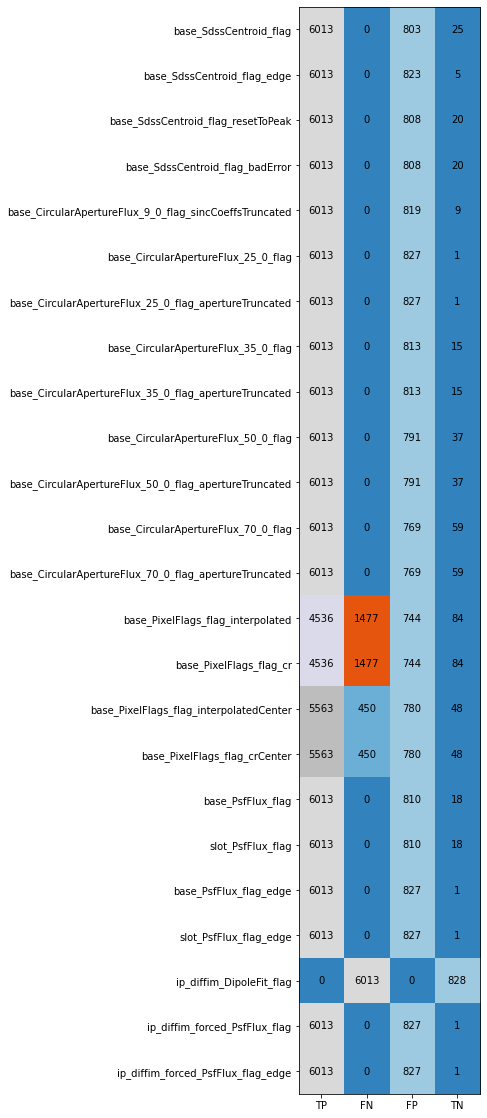

In [31]:
flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
         'ip_diffim_DipoleFit_flag_classification', 'base_PixelFlags_flag_edge',
         'base_SdssShape_flag']
flux_remov = remove_flags(flux_det, flag_list=flags)
fp_remov = remove_flags(fp, flag_list=flags)
confusion_matrix, flag_list = get_confusion_matrix(flux_remov, fp_remov, flag_col)
plot_confusion_matrix(confusion_matrix, flag_list, figsize=(50,20))

# all flags

In [21]:
print(len(flag_col))

109


In [22]:
confusion_matrix, flag_list = get_confusion_matrix(flux_det, fp, flag_col)
plot_confusion_matrix(confusion_matrix, flag_list)

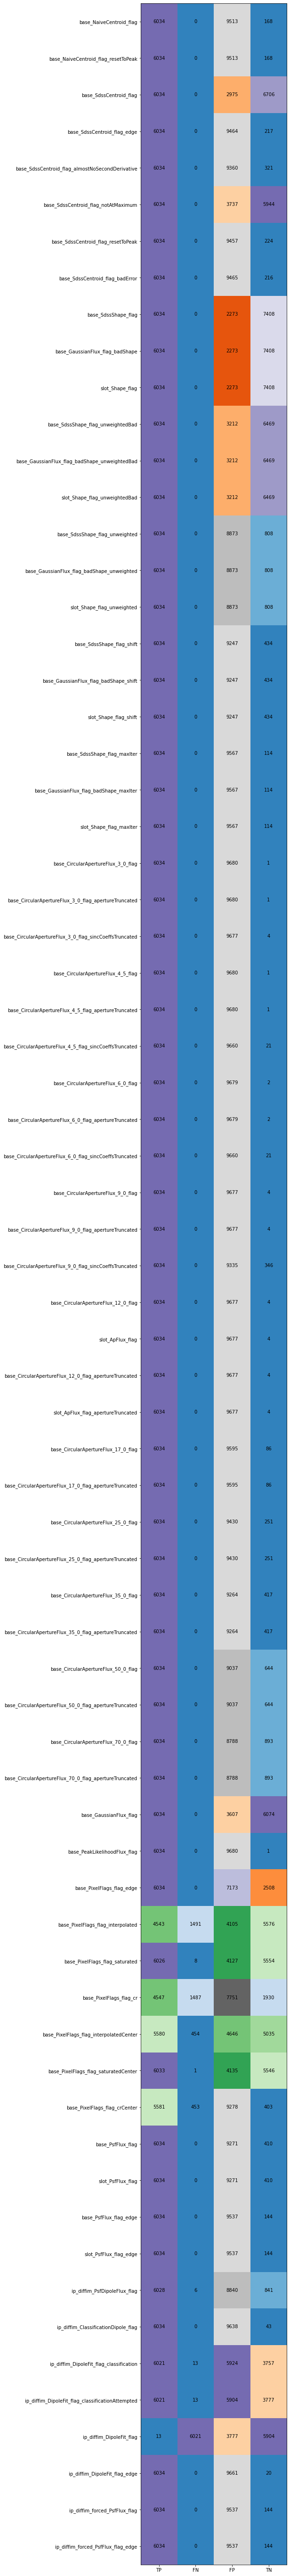

we have two tables:
fake table: it has all of detected fakes
artifact table: it has all of detected artifacts (variables have already been removed)

both tables have flags,

for a given flag:

- in fake table, if a detection does not have that flag, that detection would be called as TP, if a detection has that flag, that detection would be called FN. TP + FN = 6034.

- in artifact table, if a detection does not have that flag, that detection would be called as FP, if a detection has that flag, that detection would be called TN. FP + TN = 9681.

We want high TP and high TN.

There are many flags have the same performace. It could be good to use only one of them since some statistical learning algorithms are sensitive to linearly correlated features. (linear regression and logistic regression are not immune to the multicollinearity. Decision trees and boosted trees are immune to the multicollinearity)


Flags that could be helpful:



In [ ]:
flux_det_2 = remove_flag(flux_det, flag_list=None)